## P.S. The main idea behind this notebook is inspired from FabienDaniel Kernel Elo_world.
https://www.kaggle.com/fabiendaniel/elo-world

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc
import pickle
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# new_transactions = pd.read_csv('../input/elo-merchant-category-recommendation/new_merchant_transactions.csv', parse_dates=['purchase_date'])
# historical_transactions = pd.read_csv('../input/elo-merchant-category-recommendation/historical_transactions.csv', parse_dates=['purchase_date'])

historical_transactions = pd.read_parquet('../input/hist_trans_df.parquet.gzip')
new_transactions = pd.read_parquet('../input/new_trans_df.parquet.gzip')

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [4]:
%%time
# def read_data(input_file):
#     df = pd.read_csv(input_file)
#     df['first_active_month'] = pd.to_datetime(df['first_active_month'])
#     df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
#     return df

# train = read_data('../input/elo-merchant-category-recommendation/train.csv')
# test = read_data('../input/elo-merchant-category-recommendation/test.csv')

def read_data_v2(input_file):
    df = pd.read_parquet(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data_v2('../input/train_df.parquet.gzip')
test = read_data_v2('../input/test_df.parquet.gzip')

target = train['target']
del train['target']
gc.collect()

CPU times: user 852 ms, sys: 27.9 ms, total: 880 ms
Wall time: 879 ms


## **Feature Engineering**

In [5]:
plot_opt = 0

In [6]:
historical_transactions["category_1"] += 1
historical_transactions["category_1"].unique()

array([1, 2])

In [7]:
new_transactions["category_1"] += 1
new_transactions["category_1"].unique()

array([1, 2])

In [8]:
historical_transactions["category_2"].unique()

array([ 1., nan,  3.,  5.,  2.,  4.])

In [9]:
historical_transactions["category_2"] = historical_transactions["category_2"].fillna(0)
historical_transactions["category_2"].unique()

array([1., 0., 3., 5., 2., 4.])

In [10]:
new_transactions["category_2"].unique()

array([ 1., nan,  3.,  2.,  4.,  5.])

In [11]:
new_transactions["category_2"] = new_transactions["category_2"].fillna(0)
new_transactions["category_2"].unique()

array([1., 0., 3., 2., 4., 5.])

In [12]:
historical_transactions["category_3"].unique()

array(['A', 'B', 'C', None], dtype=object)

In [13]:
historical_transactions["category_3"] = historical_transactions["category_3"].replace({'A': 1, 'B': 2, 'C': 3, None: 0})
historical_transactions["category_3"].unique()

array([1, 2, 3, 0])

In [14]:
new_transactions["category_3"].unique()

array(['B', None, 'C', 'A'], dtype=object)

In [15]:
new_transactions["category_3"] = new_transactions["category_3"].replace({'A': 1, 'B': 2, 'C': 3, None: 0})
new_transactions["category_3"].unique()

array([2, 0, 3, 1])

In [16]:
# %%time
# if plot_opt:
#     plt.scatter(historical_transactions["category_1"], historical_transactions["category_2"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_2")
#     plt.show()

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [17]:
# historical_transactions["category_1_2_cross"] = historical_transactions["category_1"]*2 + historical_transactions["category_2"]
# np.sort(historical_transactions["category_1_2_cross"].unique())

In [18]:
# %%time
# if plot_opt:
#     plt.scatter(new_transactions["category_1"], new_transactions["category_2"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_2")
#     plt.show()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


In [19]:
# new_transactions["category_1_2_cross"] = new_transactions["category_1"]*2 + new_transactions["category_2"]
# np.sort(new_transactions["category_1_2_cross"].unique())

In [20]:
# %%time
# if plot_opt:
#     plt.scatter(historical_transactions["category_1"]+2, historical_transactions["category_3"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_3")
#     plt.show()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.58 µs


In [21]:
# historical_transactions["category_1_3_cross"] = (historical_transactions["category_1"]+2) * historical_transactions["category_3"]
# np.sort(historical_transactions["category_1_3_cross"].unique())

array([ 0,  3,  4,  6,  8,  9, 12])

In [22]:
# %%time
# if plot_opt:
#     plt.scatter(new_transactions["category_1"], new_transactions["category_3"])
#     plt.xlabel("category_1")
#     plt.ylabel("category_3")
#     plt.show()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [23]:
# new_transactions["category_1_3_cross"] = (new_transactions["category_1"]+2) * new_transactions["category_3"]
# np.sort(new_transactions["category_1_3_cross"].unique())

array([ 0,  3,  4,  6,  8,  9, 12])

In [24]:
# %%time
# if plot_opt:
#     plt.scatter(historical_transactions["category_2"]+6, historical_transactions["category_3"])
#     plt.xlabel("category_2")
#     plt.ylabel("category_3")
#     plt.show()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


In [25]:
# historical_transactions["category_2_3_cross"] = (historical_transactions["category_2"]+6) * historical_transactions["category_3"]
# np.sort(historical_transactions["category_2_3_cross"].unique())

array([ 0.,  6.,  7.,  8.,  9., 10., 11., 12., 14., 16., 18., 20., 21.,
       22., 24., 27., 30., 33.])

In [26]:
# %%time
# if plot_opt:
#     plt.scatter(new_transactions["category_2"]+6, new_transactions["category_3"])
#     plt.xlabel("category_2")
#     plt.ylabel("category_3")
#     plt.show()

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [27]:
# new_transactions["category_2_3_cross"] = (new_transactions["category_2"]+6) * new_transactions["category_3"]
# np.sort(new_transactions["category_2_3_cross"].unique())

array([ 0.,  6.,  7.,  8.,  9., 10., 11., 12., 14., 16., 18., 20., 21.,
       22., 24., 27., 30., 33.])

In [28]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,category_1_3_cross,category_2_3_cross
0,1,C_ID_4e6213e9bc,88,1,0,1,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,3,7.0
1,1,C_ID_4e6213e9bc,88,1,0,1,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,3,7.0
2,1,C_ID_4e6213e9bc,88,1,0,1,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,3,7.0
3,1,C_ID_4e6213e9bc,88,1,0,1,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,3,7.0
4,1,C_ID_4e6213e9bc,88,1,0,1,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,3,7.0


In [ ]:
def category_make_cross_feat():
    df["category_1_3_cross"] = (df["category_1"]+2) * df["category_3"]
    df["category_2_3_cross"] = (df["category_2"]+6) * df["category_3"]
    return df

historical_transactions = category_make_cross_feat(historical_transactions)
new_transactions = category_make_cross_feat(new_transactions)

In [29]:
%%time
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 
                                                                           'category_3',
                                                                           'category_1_3_cross',
                                                                           'category_2_3_cross'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 
                                                             'category_3',
                                                             'category_1_3_cross',
                                                             'category_2_3_cross'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean', 'min', 'std', 'count']} # max is all 1's, useless
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]
gc.collect()

Mem. usage decreased to 2054.51 Mb (43.5% reduction)
Mem. usage decreased to 134.79 Mb (45.0% reduction)
CPU times: user 15.9 s, sys: 8.46 s, total: 24.3 s
Wall time: 24.3 s


In [30]:
auth_mean.head()

,card_id,authorized_flag_sum,authorized_flag_mean,authorized_flag_min,authorized_flag_std,authorized_flag_count
0,C_ID_00007093c1,114.0,0.765101,0,0.425366,149
1,C_ID_0001238066,120.0,0.975610,0,0.154888,123
2,C_ID_0001506ef0,62.0,0.939394,0,0.240435,66
3,C_ID_0001793786,189.0,0.875000,0,0.331487,216
4,C_ID_000183fdda,137.0,0.951389,0,0.215804,144


In [31]:
%%time
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month
gc.collect()

CPU times: user 1.01 s, sys: 80.1 ms, total: 1.09 s
Wall time: 1.09 s


In [32]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_0.0,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_0,category_3_1,category_3_2,category_3_3,category_1_3_cross_0,category_1_3_cross_3,category_1_3_cross_4,category_1_3_cross_6,category_1_3_cross_8,category_1_3_cross_9,category_1_3_cross_12,category_2_3_cross_0.0,category_2_3_cross_6.0,category_2_3_cross_7.0,category_2_3_cross_8.0,category_2_3_cross_9.0,category_2_3_cross_10.0,category_2_3_cross_11.0,category_2_3_cross_12.0,category_2_3_cross_14.0,category_2_3_cross_16.0,category_2_3_cross_18.0,category_2_3_cross_20.0,category_2_3_cross_21.0,category_2_3_cross_22.0,category_2_3_cross_24.0,category_2_3_cross_27.0,category_2_3_cross_30.0,category_2_3_cross_33.0,purchase_month
0,1,C_ID_415bb3a509,107,1,1,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,9,19,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3
1,1,C_ID_415bb3a509,140,1,1,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,9,19,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3
2,1,C_ID_415bb3a509,330,1,1,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,9,14,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4
3,1,C_ID_415bb3a509,-1,2,1,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,-1,8,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3
4,1,C_ID_ef55cf8d4b,-1,2,1,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,-1,29,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3


In [33]:
%%time
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_1': ['mean'],
        'category_3_2': ['mean'],
        'category_3_3': ['mean'],
        'category_1_3_cross_3': ['mean'],
        'category_1_3_cross_4': ['mean'],
        'category_1_3_cross_6': ['mean'],
        'category_1_3_cross_8': ['mean'],
        'category_1_3_cross_9': ['mean'],
        'category_1_3_cross_12': ['mean'],
        'category_2_3_cross_7.0': ['mean'],
        'category_2_3_cross_8.0': ['mean'],
        'category_2_3_cross_9.0': ['mean'],
        'category_2_3_cross_10.0': ['mean'],
        'category_2_3_cross_11.0': ['mean'],
        'category_2_3_cross_12.0': ['mean'],
        'category_2_3_cross_14.0': ['mean'],
        'category_2_3_cross_16.0': ['mean'],
        'category_2_3_cross_20.0': ['mean'],
        'category_2_3_cross_21.0': ['mean'],
        'category_2_3_cross_22.0': ['mean'],
        'category_2_3_cross_24.0': ['mean'],
        'category_2_3_cross_27.0': ['mean'],
        'category_2_3_cross_30.0': ['mean'],
        'category_2_3_cross_33.0': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std', 'count'], #one count is enough, others are just the same
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

gc.collect()

CPU times: user 32.7 ms, sys: 0 ns, total: 32.7 ms
Wall time: 32.6 ms


In [34]:
%%time
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]
gc.collect()

CPU times: user 26.3 s, sys: 361 ms, total: 26.6 s
Wall time: 26.6 s


In [35]:
# # history[["hist_purchase_amount_count", "hist_installments_count", "hist_purchase_month_count"]].head(500)
# history.head(500)

In [36]:
%%time
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]
gc.collect()

CPU times: user 1min 22s, sys: 5.99 s, total: 1min 28s
Wall time: 1min 28s


In [37]:
%%time
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]
gc.collect()

CPU times: user 26.5 s, sys: 320 ms, total: 26.8 s
Wall time: 26.7 s


In [38]:
%%time
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
#             'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
#             'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'purchase_amount': ['count', 'sum'],
            'installments': ['count', 'sum'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]
gc.collect()

CPU times: user 1.65 s, sys: 27.2 ms, total: 1.67 s
Wall time: 1.67 s


In [39]:
%%time
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
gc.collect()

Train Shape: (201917, 192)
Test Shape: (123623, 192)
CPU times: user 2.16 s, sys: 395 ms, total: 2.55 s
Wall time: 2.55 s


In [40]:
def generate_feat(df):
    # Feature crosses
    df["feature_1_2_cross"] = df["feature_1"] + (df["feature_2"]-1)*5
    df["feature_1_3_cross"] = df["feature_1"] + df["feature_3"]*3
    df["feature_2_3_cross"] = df["feature_2"] + df["feature_3"]*3
    df = pd.get_dummies(df, columns=["feature_1_2_cross", "feature_1_3_cross", "feature_2_3_cross"])
    
    return df

train = generate_feat(train)
test = generate_feat(test)



In [41]:
train.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_2_3_cross_9.0_mean,hist_category_1_3_cross_12_mean,hist_category_2_3_cross_21.0_mean,hist_category_1_3_cross_3_mean,hist_category_1_3_cross_8_mean,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_category_3_3_mean,hist_category_2_3_cross_20.0_mean,hist_state_id_nunique,hist_category_2_3_cross_7.0_mean,hist_category_2_2.0_mean,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_category_2_4.0_mean,hist_category_2_3_cross_16.0_mean,hist_merchant_id_nunique,hist_category_1_3_cross_6_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_5.0_mean,hist_category_2_1.0_mean,hist_category_3_2_mean,hist_subsector_id_nunique,hist_category_2_3_cross_22.0_mean,hist_category_2_3_cross_33.0_mean,hist_category_2_3_cross_10.0_mean,hist_merchant_category_id_nunique,hist_category_2_3_cross_8.0_mean,hist_category_2_3_cross_27.0_mean,hist_category_1_3_cross_4_mean,hist_category_2_3.0_mean,hist_category_1_3_cross_9_mean,hist_category_2_3_cross_24.0_mean,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_amount_count,hist_category_2_3_cross_11.0_mean,hist_month_lag_min,hist_month_lag_max,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_category_2_3_cross_12.0_mean,hist_city_id_nunique,hist_category_3_1_mean,hist_category_2_3_cross_14.0_mean,hist_category_2_3_cross_30.0_mean,auth_transactions_count,auth_category_2_3_cross_9.0_mean,auth_category_1_3_cross_12_mean,auth_category_2_3_cross_21.0_mean,auth_category_1_3_cross_3_mean,auth_category_1_3_cross_8_mean,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_category_3_3_mean,auth_category_2_3_cross_20.0_mean,auth_state_id_nunique,auth_category_2_3_cross_7.0_mean,auth_category_2_2.0_mean,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_category_2_4.0_mean,auth_category_2_3_cross_16.0_mean,auth_merchant_id_nunique,auth_category_1_3_cross_6_mean,auth_category_1_sum,auth_category_1_mean,auth_category_2_5.0_mean,auth_category_2_1.0_mean,auth_category_3_2_mean,auth_subsector_id_nunique,auth_category_2_3_cross_22.0_mean,auth_category_2_3_cross_33.0_mean,auth_category_2_3_cross_10.0_mean,auth_merchant_category_id_nunique,auth_category_2_3_cross_8.0_mean,auth_category_2_3_cross_27.0_mean,auth_category_1_3_cross_4_mean,auth_category_2_3.0_mean,auth_category_1_3_cross_9_mean,auth_category_2_3_cross_24.0_mean,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_purchase_amount_count,auth_category_2_3_cross_11.0_mean,auth_month_lag_min,auth_month_lag_max,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_category_2_3_cross_12.0_mean,auth_city_id_nunique,auth_category_3_1_mean,auth_category_2_3_cross_14.0_mean,auth_category_2_3_cross_30.0_mean,new_transactions_count,new_category_2_3_cross_9.0_mean,new_category_1_3_cross_12_mean,new_category_2_3_cross_21.0_mean,new_category_1_3_cross_3_mean,new_category_1_3_cross_8_mean,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_category_3_3_mean,new_category_2_3_cross_20.0_mean,new_state_id_nunique,new_category_2_3_cross_7.0_mean,new_category_2_2.0_mean,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_category_2_4.0_mean,new_category_2_3_cross_16.0_mean,new_merchant_id_nunique,new_category_1_3_cross_6_mean,new_category_1_sum,new_category_1_mean,new_category_2_5.0_mean,new_category_2_1.0_mean,new_category_3_2_mean,new_subsector_id_nunique,new_category_2_3_cross_22.0_mean,new_category_2_3_cross_33.0_mean,new_catego

In [42]:
def power_2_3_feat(df, feat_list):
    for feat in feat_list:
        df[feat+"_power2"] = df[feat]**2
        df[feat+"_power3"] = df[feat]**3
    return df

feat_list = ["elapsed_time", "hist_purchase_date_ptp"]
train = power_2_3_feat(train, feat_list)
test = power_2_3_feat(test, feat_list)

In [43]:
corrmat = train.corr()

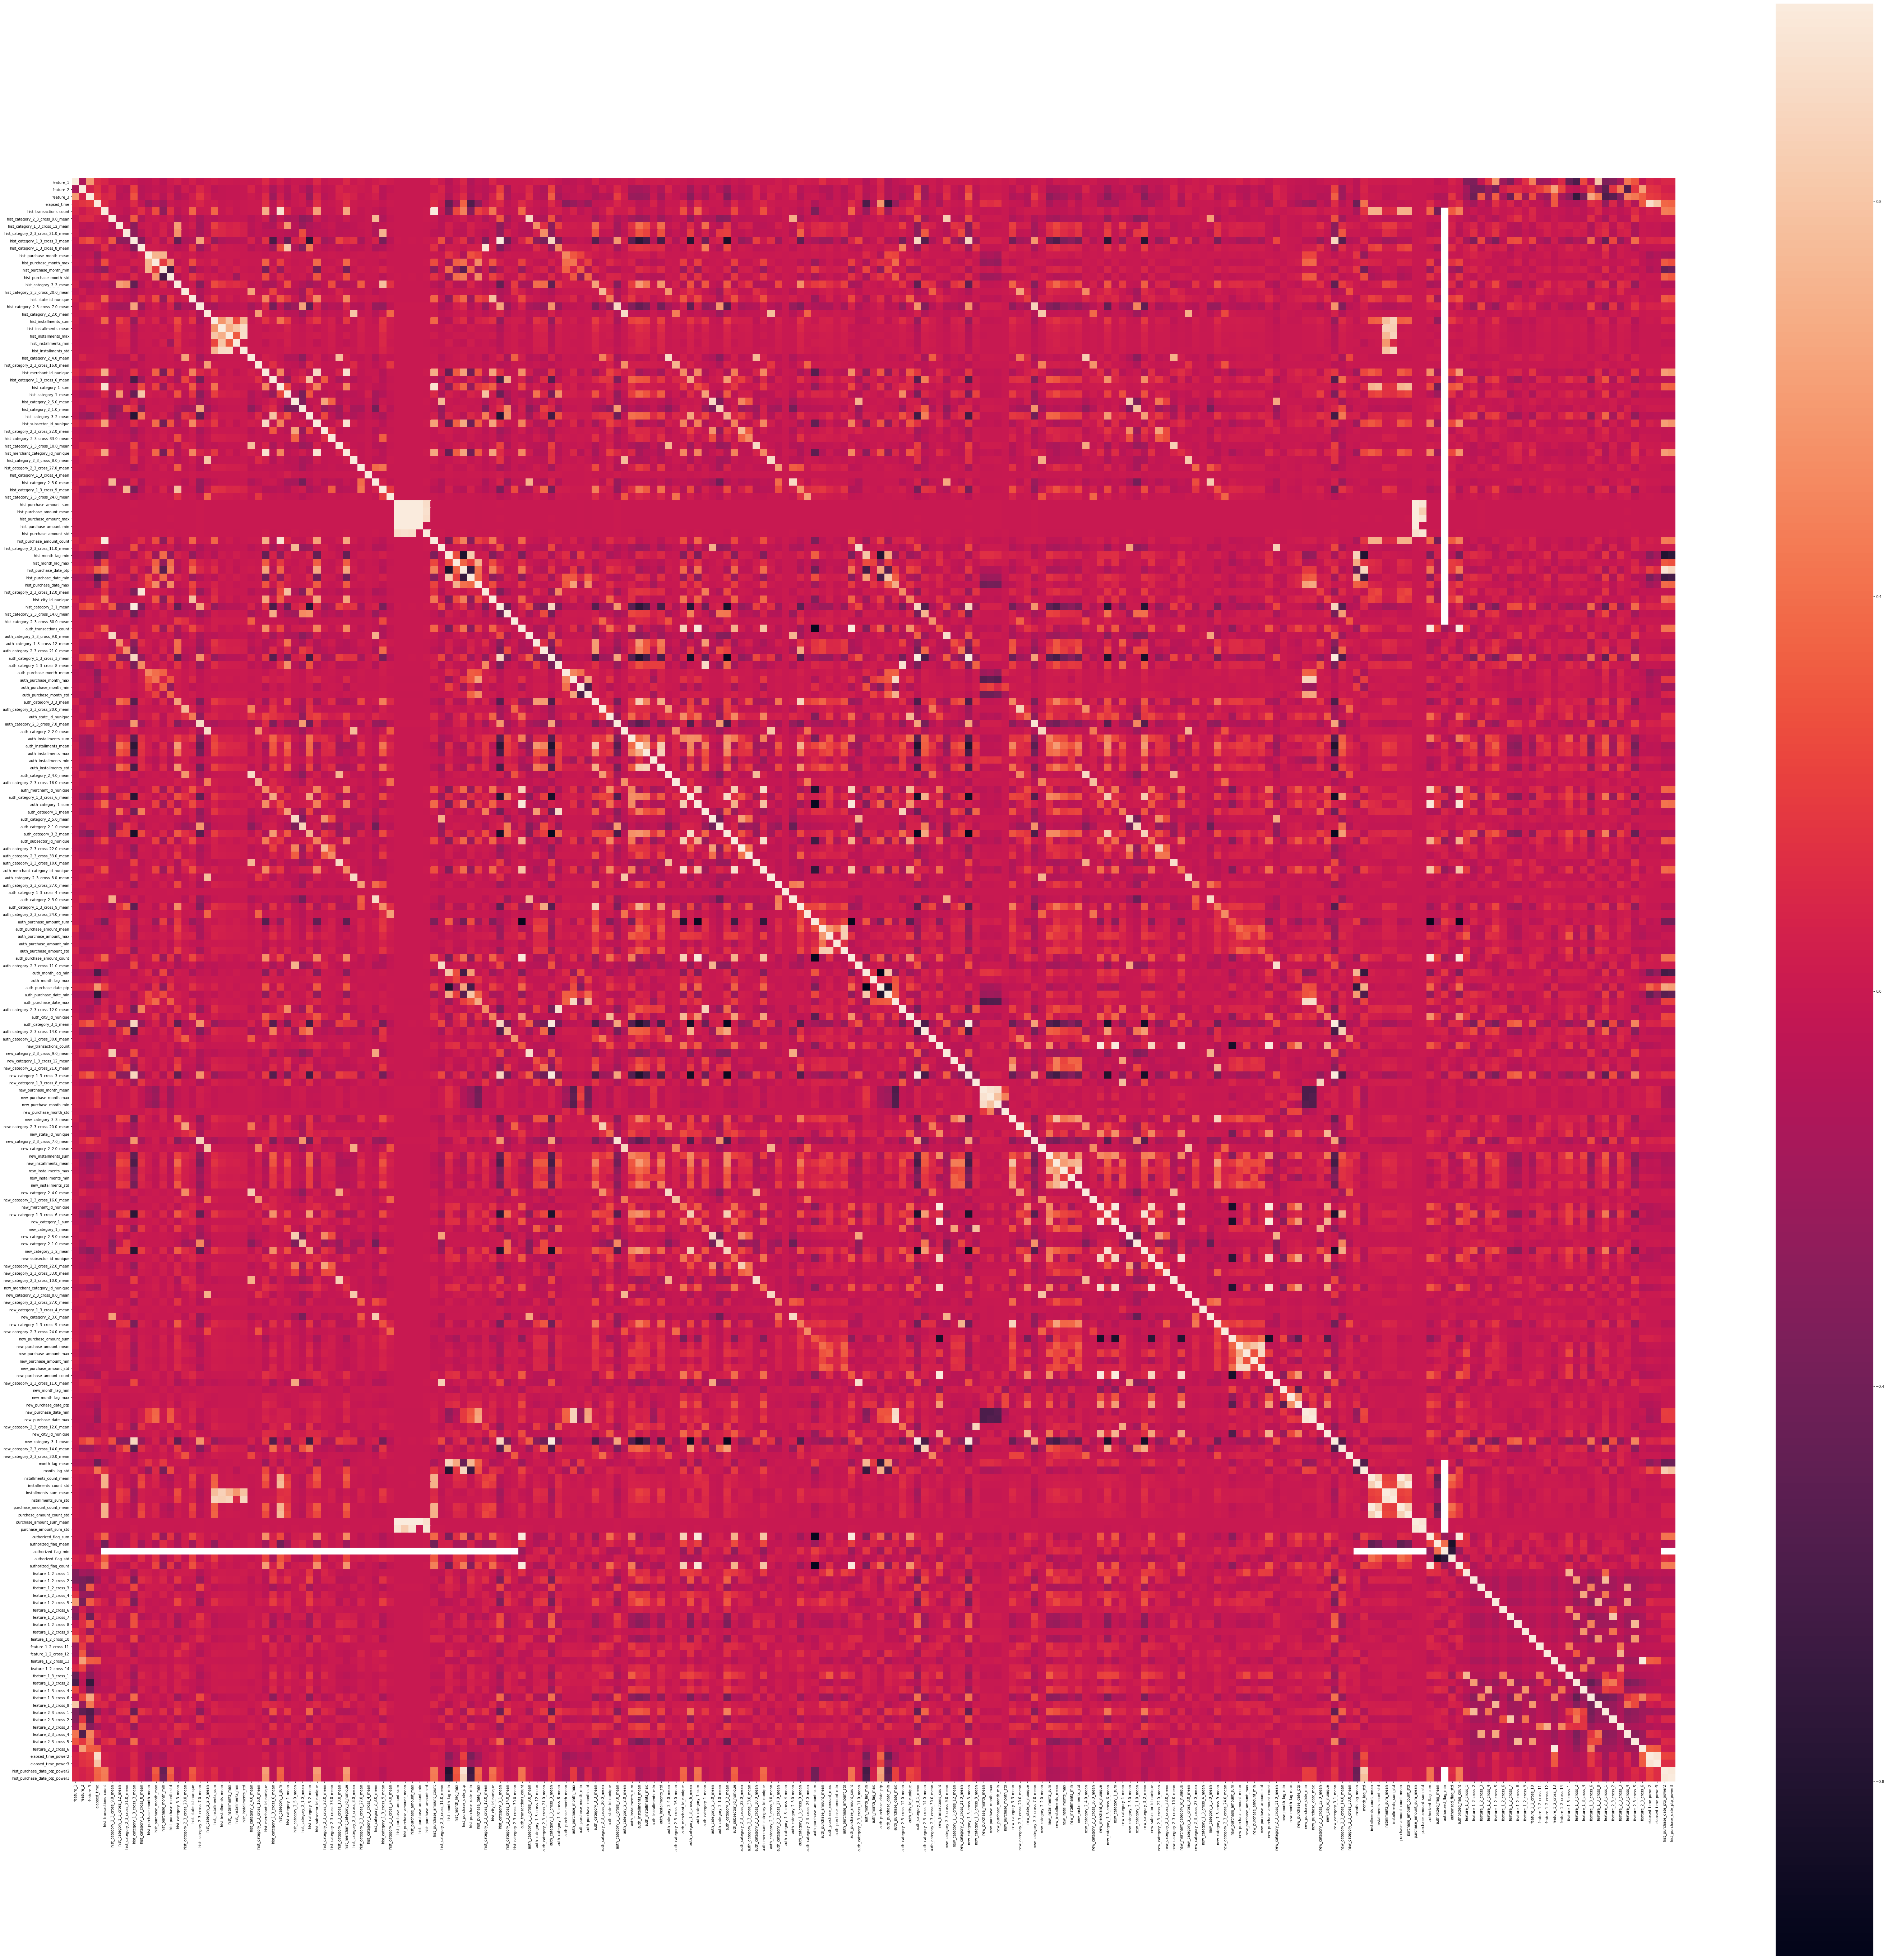

In [44]:
f, ax = plt.subplots(figsize=(100, 100))
sns.heatmap(corrmat, vmax=1.0, square=True)

In [45]:
f.savefig("../img/corr.png")

In [46]:
remove_feat_list = ['authorized_flag_min', 
                    'hist_purchase_amount_sum',
                    'hist_purchase_amount_max',
                    'hist_purchase_amount_min',
                    'hist_purchase_amount_std',
                    'hist_installments_sum',
                    'hist_installments_max',
                    'hist_installments_min',
                    'hist_installments_std',
                   ]
train = train.drop(remove_feat_list, axis=1)
test = test.drop(remove_feat_list, axis=1)

In [47]:
corrmat = train.corr()

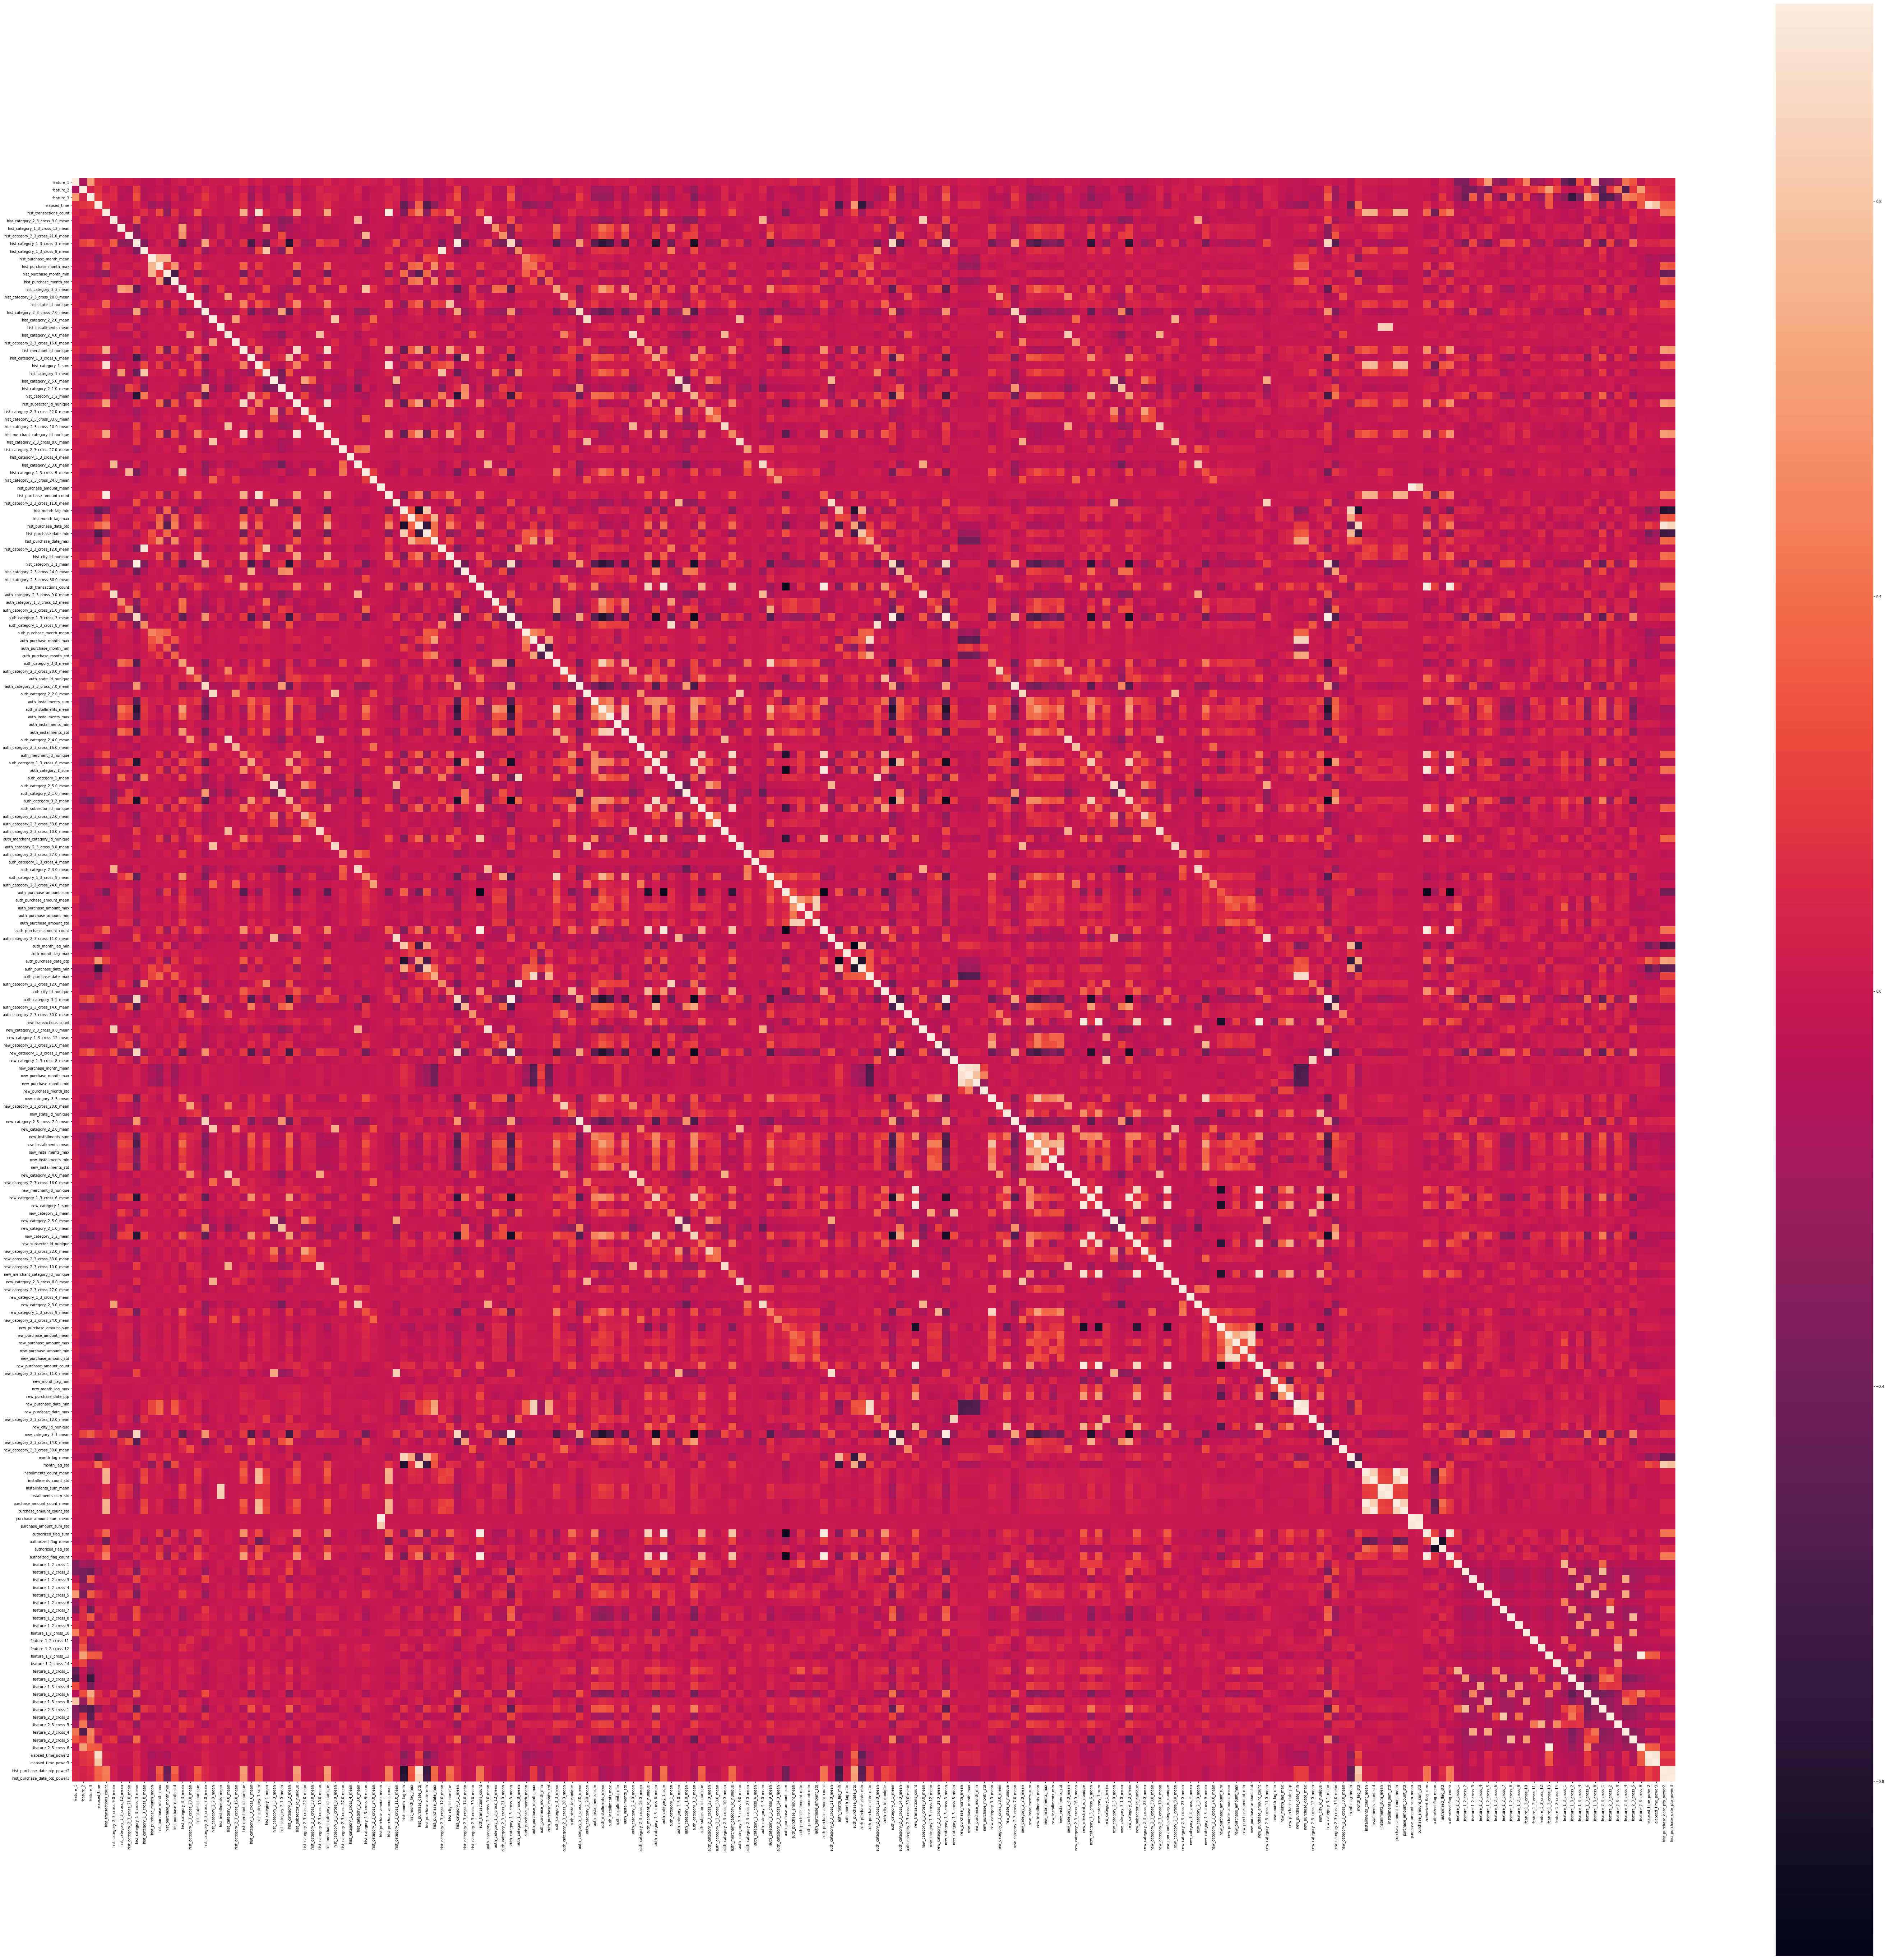

In [48]:
f, ax = plt.subplots(figsize=(100, 100))
sns.heatmap(corrmat, vmax=1.0, square=True)

In [49]:
f.savefig("../img/corr_after_feat_removal.png")

In [50]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

In [51]:
train = train.fillna(0)
test = test.fillna(0)

In [52]:
# with open('../input/feat_list.pkl', 'rb') as f:
#     feat_list = pickle.load(f)

# train = train[feat_list]
# test = test[feat_list]

KeyError: "[('feature_1', 'feature_2', 'feature_3', 'elapsed_time', 'hist_transactions_count', 'hist_category_2_3_cross_24.0_mean', 'hist_category_2_3_cross_10.0_mean', 'hist_subsector_id_nunique', 'hist_category_2_1.0_mean', 'hist_purchase_month_mean', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_category_2_3_cross_12.0_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_state_id_nunique', 'hist_category_2_3_cross_9.0_mean', 'hist_category_1_3_cross_3_mean', 'hist_category_2_3_cross_8.0_mean', 'hist_category_2_3_cross_33.0_mean', 'hist_category_2_3_cross_16.0_mean', 'hist_category_2_3_cross_20.0_mean', 'hist_category_2_3_cross_30.0_mean', 'hist_merchant_id_nunique', 'hist_category_3_1_mean', 'hist_category_2_4.0_mean', 'hist_category_2_3_cross_21.0_mean', 'hist_category_1_3_cross_6_mean', 'hist_category_1_3_cross_8_mean', 'hist_category_2_2.0_mean', 'hist_category_2_3.0_mean', 'hist_installments_mean', 'hist_category_3_3_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_5.0_mean', 'hist_category_1_3_cross_9_mean', 'hist_category_2_3_cross_27.0_mean', 'hist_city_id_nunique', 'hist_category_2_3_cross_11.0_mean', 'hist_category_2_3_cross_22.0_mean', 'hist_purchase_amount_mean', 'hist_purchase_amount_count', 'hist_category_2_3_cross_7.0_mean', 'hist_merchant_category_id_nunique', 'hist_category_2_3_cross_14.0_mean', 'hist_category_1_3_cross_12_mean', 'hist_category_3_2_mean', 'auth_transactions_count', 'auth_category_2_3_cross_24.0_mean', 'auth_category_2_3_cross_10.0_mean', 'auth_subsector_id_nunique', 'auth_category_2_1.0_mean', 'auth_purchase_month_mean', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_purchase_month_std', 'auth_category_2_3_cross_12.0_mean', 'auth_purchase_date_ptp', 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_min', 'auth_month_lag_max', 'auth_state_id_nunique', 'auth_category_2_3_cross_9.0_mean', 'auth_category_1_3_cross_3_mean', 'auth_category_2_3_cross_8.0_mean', 'auth_category_2_3_cross_33.0_mean', 'auth_category_2_3_cross_16.0_mean', 'auth_category_2_3_cross_20.0_mean', 'auth_category_2_3_cross_30.0_mean', 'auth_merchant_id_nunique', 'auth_category_2_4.0_mean', 'auth_category_2_3_cross_21.0_mean', 'auth_category_1_3_cross_6_mean', 'auth_category_1_3_cross_8_mean', 'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean', 'auth_installments_sum', 'auth_installments_mean', 'auth_installments_max', 'auth_installments_min', 'auth_installments_std', 'auth_category_3_3_mean', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_5.0_mean', 'auth_category_1_3_cross_9_mean', 'auth_category_2_3_cross_27.0_mean', 'auth_city_id_nunique', 'auth_category_2_3_cross_11.0_mean', 'auth_category_2_3_cross_22.0_mean', 'auth_purchase_amount_sum', 'auth_purchase_amount_mean', 'auth_purchase_amount_max', 'auth_purchase_amount_min', 'auth_purchase_amount_std', 'auth_purchase_amount_count', 'auth_category_2_3_cross_7.0_mean', 'auth_merchant_category_id_nunique', 'auth_category_2_3_cross_14.0_mean', 'auth_category_1_3_cross_12_mean', 'auth_category_3_2_mean', 'new_transactions_count', 'new_category_2_3_cross_24.0_mean', 'new_category_2_3_cross_10.0_mean', 'new_subsector_id_nunique', 'new_category_2_1.0_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_category_2_3_cross_12.0_mean', 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max', 'new_month_lag_min', 'new_month_lag_max', 'new_state_id_nunique', 'new_category_2_3_cross_9.0_mean', 'new_category_1_3_cross_3_mean', 'new_category_2_3_cross_8.0_mean', 'new_category_2_3_cross_33.0_mean', 'new_category_2_3_cross_20.0_mean', 'new_category_2_3_cross_30.0_mean', 'new_merchant_id_nunique', 'new_category_3_1_mean', 'new_category_2_4.0_mean', 'new_category_2_3_cross_21.0_mean', 'new_category_1_3_cross_6_mean', 'new_category_1_3_cross_8_mean', 'new_category_2_2.0_mean', 'new_category_2_3.0_mean', 'new_installments_sum', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_category_3_3_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_2_5.0_mean', 'new_category_1_3_cross_9_mean', 'new_category_2_3_cross_27.0_mean', 'new_city_id_nunique', 'new_category_2_3_cross_11.0_mean', 'new_category_2_3_cross_22.0_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_amount_count', 'new_category_2_3_cross_7.0_mean', 'new_merchant_category_id_nunique', 'new_category_2_3_cross_14.0_mean', 'new_category_1_3_cross_12_mean', 'new_category_3_2_mean', 'new_category_1_3_cross_4_mean', 'month_lag_mean', 'month_lag_std', 'installments_count_mean', 'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean', 'purchase_amount_sum_std', 'authorized_flag_mean', 'authorized_flag_std', 'authorized_flag_count', 'feature_1_2_cross_1', 'feature_1_2_cross_2', 'feature_1_2_cross_3', 'feature_1_2_cross_4', 'feature_1_2_cross_5', 'feature_1_2_cross_7', 'feature_1_2_cross_8', 'feature_1_2_cross_9', 'feature_1_2_cross_10', 'feature_1_2_cross_11', 'feature_1_2_cross_12', 'feature_1_2_cross_13', 'feature_1_2_cross_14', 'feature_1_3_cross_1', 'feature_1_3_cross_2', 'feature_1_3_cross_4', 'feature_1_3_cross_6', 'feature_1_3_cross_8', 'feature_2_3_cross_1', 'feature_2_3_cross_2', 'feature_2_3_cross_3', 'feature_2_3_cross_4', 'feature_2_3_cross_5', 'feature_2_3_cross_6', 'elapsed_time_power2', 'elapsed_time_power3', 'hist_purchase_date_ptp_power2', 'hist_purchase_date_ptp_power3', 'feature_1', 'feature_2', 'feature_3', 'elapsed_time', 'hist_transactions_count', 'hist_category_2_3_cross_24.0_mean', 'hist_category_2_3_cross_10.0_mean', 'hist_subsector_id_nunique', 'hist_category_2_1.0_mean', 'hist_purchase_month_mean', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_category_2_3_cross_12.0_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_state_id_nunique', 'hist_category_2_3_cross_9.0_mean', 'hist_category_1_3_cross_3_mean', 'hist_category_2_3_cross_8.0_mean', 'hist_category_2_3_cross_33.0_mean', 'hist_category_2_3_cross_16.0_mean', 'hist_category_2_3_cross_20.0_mean', 'hist_category_2_3_cross_30.0_mean', 'hist_merchant_id_nunique', 'hist_category_3_1_mean', 'hist_category_2_4.0_mean', 'hist_category_2_3_cross_21.0_mean', 'hist_category_1_3_cross_6_mean', 'hist_category_1_3_cross_8_mean', 'hist_category_2_2.0_mean', 'hist_category_2_3.0_mean', 'hist_installments_mean', 'hist_category_3_3_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_5.0_mean', 'hist_category_1_3_cross_9_mean', 'hist_category_2_3_cross_27.0_mean', 'hist_city_id_nunique', 'hist_category_2_3_cross_11.0_mean', 'hist_category_2_3_cross_22.0_mean', 'hist_purchase_amount_mean', 'hist_purchase_amount_count', 'hist_category_2_3_cross_7.0_mean', 'hist_merchant_category_id_nunique', 'hist_category_2_3_cross_14.0_mean', 'hist_category_1_3_cross_12_mean', 'hist_category_3_2_mean', 'hist_category_1_3_cross_4_mean', 'auth_transactions_count', 'auth_category_2_3_cross_24.0_mean', 'auth_category_2_3_cross_10.0_mean', 'auth_subsector_id_nunique', 'auth_category_2_1.0_mean', 'auth_purchase_month_mean', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_purchase_month_std', 'auth_category_2_3_cross_12.0_mean', 'auth_purchase_date_ptp', 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_min', 'auth_month_lag_max', 'auth_state_id_nunique', 'auth_category_2_3_cross_9.0_mean', 'auth_category_1_3_cross_3_mean', 'auth_category_2_3_cross_8.0_mean', 'auth_category_2_3_cross_33.0_mean', 'auth_category_2_3_cross_16.0_mean', 'auth_category_2_3_cross_20.0_mean', 'auth_category_2_3_cross_30.0_mean', 'auth_merchant_id_nunique', 'auth_category_2_4.0_mean', 'auth_category_2_3_cross_21.0_mean', 'auth_category_1_3_cross_6_mean', 'auth_category_1_3_cross_8_mean', 'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean', 'auth_installments_sum', 'auth_installments_mean', 'auth_installments_max', 'auth_installments_min', 'auth_installments_std', 'auth_category_3_3_mean', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_5.0_mean', 'auth_category_1_3_cross_9_mean', 'auth_category_2_3_cross_27.0_mean', 'auth_city_id_nunique', 'auth_category_2_3_cross_11.0_mean', 'auth_category_2_3_cross_22.0_mean', 'auth_purchase_amount_sum', 'auth_purchase_amount_mean', 'auth_purchase_amount_max', 'auth_purchase_amount_min', 'auth_purchase_amount_std', 'auth_purchase_amount_count', 'auth_category_2_3_cross_7.0_mean', 'auth_merchant_category_id_nunique', 'auth_category_2_3_cross_14.0_mean', 'auth_category_1_3_cross_12_mean', 'auth_category_3_2_mean', 'new_transactions_count', 'new_category_2_3_cross_24.0_mean', 'new_category_2_3_cross_10.0_mean', 'new_subsector_id_nunique', 'new_category_2_1.0_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_category_2_3_cross_12.0_mean', 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max', 'new_month_lag_min', 'new_month_lag_max', 'new_state_id_nunique', 'new_category_2_3_cross_9.0_mean', 'new_category_1_3_cross_3_mean', 'new_category_2_3_cross_8.0_mean', 'new_category_2_3_cross_33.0_mean', 'new_category_2_3_cross_16.0_mean', 'new_category_2_3_cross_20.0_mean', 'new_category_2_3_cross_30.0_mean', 'new_merchant_id_nunique', 'new_category_3_1_mean', 'new_category_2_4.0_mean', 'new_category_2_3_cross_21.0_mean', 'new_category_1_3_cross_6_mean', 'new_category_1_3_cross_8_mean', 'new_category_2_2.0_mean', 'new_category_2_3.0_mean', 'new_installments_sum', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_category_3_3_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_2_5.0_mean', 'new_category_1_3_cross_9_mean', 'new_category_2_3_cross_27.0_mean', 'new_city_id_nunique', 'new_category_2_3_cross_11.0_mean', 'new_category_2_3_cross_22.0_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_amount_count', 'new_category_2_3_cross_7.0_mean', 'new_merchant_category_id_nunique', 'new_category_2_3_cross_14.0_mean', 'new_category_1_3_cross_12_mean', 'new_category_3_2_mean', 'new_category_1_3_cross_4_mean', 'month_lag_mean', 'month_lag_std', 'installments_count_mean', 'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean', 'purchase_amount_sum_std', 'authorized_flag_sum', 'authorized_flag_mean', 'authorized_flag_std', 'authorized_flag_count', 'feature_1_2_cross_2', 'feature_1_2_cross_4', 'feature_1_2_cross_5', 'feature_1_2_cross_7', 'feature_1_2_cross_8', 'feature_1_2_cross_9', 'feature_1_2_cross_10', 'feature_1_2_cross_11', 'feature_1_2_cross_12', 'feature_1_2_cross_13', 'feature_1_2_cross_14', 'feature_1_3_cross_1', 'feature_1_3_cross_2', 'feature_1_3_cross_4', 'feature_1_3_cross_6', 'feature_1_3_cross_8', 'feature_2_3_cross_1', 'feature_2_3_cross_2', 'feature_2_3_cross_3', 'feature_2_3_cross_4', 'feature_2_3_cross_5', 'feature_2_3_cross_6', 'elapsed_time_power2', 'elapsed_time_power3', 'hist_purchase_date_ptp_power2', 'hist_purchase_date_ptp_power3', 'feature_1', 'feature_2', 'feature_3', 'elapsed_time', 'hist_transactions_count', 'hist_category_2_3_cross_24.0_mean', 'hist_category_2_3_cross_10.0_mean', 'hist_subsector_id_nunique', 'hist_category_2_1.0_mean', 'hist_purchase_month_mean', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_category_2_3_cross_12.0_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_state_id_nunique', 'hist_category_2_3_cross_9.0_mean', 'hist_category_1_3_cross_3_mean', 'hist_category_2_3_cross_8.0_mean', 'hist_category_2_3_cross_33.0_mean', 'hist_category_2_3_cross_16.0_mean', 'hist_category_2_3_cross_20.0_mean', 'hist_category_2_3_cross_30.0_mean', 'hist_merchant_id_nunique', 'hist_category_3_1_mean', 'hist_category_2_4.0_mean', 'hist_category_2_3_cross_21.0_mean', 'hist_category_1_3_cross_6_mean', 'hist_category_1_3_cross_8_mean', 'hist_category_2_2.0_mean', 'hist_category_2_3.0_mean', 'hist_installments_mean', 'hist_category_3_3_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_5.0_mean', 'hist_category_1_3_cross_9_mean', 'hist_category_2_3_cross_27.0_mean', 'hist_city_id_nunique', 'hist_category_2_3_cross_11.0_mean', 'hist_category_2_3_cross_22.0_mean', 'hist_purchase_amount_mean', 'hist_purchase_amount_count', 'hist_category_2_3_cross_7.0_mean', 'hist_merchant_category_id_nunique', 'hist_category_2_3_cross_14.0_mean', 'hist_category_1_3_cross_12_mean', 'hist_category_3_2_mean', 'hist_category_1_3_cross_4_mean', 'auth_transactions_count', 'auth_category_2_3_cross_24.0_mean', 'auth_category_2_3_cross_10.0_mean', 'auth_subsector_id_nunique', 'auth_category_2_1.0_mean', 'auth_purchase_month_mean', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_purchase_month_std', 'auth_category_2_3_cross_12.0_mean', 'auth_purchase_date_ptp', 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_min', 'auth_month_lag_max', 'auth_state_id_nunique', 'auth_category_2_3_cross_9.0_mean', 'auth_category_1_3_cross_3_mean', 'auth_category_2_3_cross_8.0_mean', 'auth_category_2_3_cross_33.0_mean', 'auth_category_2_3_cross_16.0_mean', 'auth_category_2_3_cross_20.0_mean', 'auth_category_2_3_cross_30.0_mean', 'auth_merchant_id_nunique', 'auth_category_2_4.0_mean', 'auth_category_2_3_cross_21.0_mean', 'auth_category_1_3_cross_6_mean', 'auth_category_1_3_cross_8_mean', 'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean', 'auth_installments_sum', 'auth_installments_mean', 'auth_installments_max', 'auth_installments_min', 'auth_installments_std', 'auth_category_3_3_mean', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_5.0_mean', 'auth_category_1_3_cross_9_mean', 'auth_category_2_3_cross_27.0_mean', 'auth_city_id_nunique', 'auth_category_2_3_cross_11.0_mean', 'auth_category_2_3_cross_22.0_mean', 'auth_purchase_amount_sum', 'auth_purchase_amount_mean', 'auth_purchase_amount_max', 'auth_purchase_amount_min', 'auth_purchase_amount_std', 'auth_purchase_amount_count', 'auth_category_2_3_cross_7.0_mean', 'auth_merchant_category_id_nunique', 'auth_category_2_3_cross_14.0_mean', 'auth_category_1_3_cross_12_mean', 'auth_category_3_2_mean', 'new_transactions_count', 'new_category_2_3_cross_24.0_mean', 'new_category_2_3_cross_10.0_mean', 'new_subsector_id_nunique', 'new_category_2_1.0_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_category_2_3_cross_12.0_mean', 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max', 'new_month_lag_min', 'new_month_lag_max', 'new_state_id_nunique', 'new_category_2_3_cross_9.0_mean', 'new_category_1_3_cross_3_mean', 'new_category_2_3_cross_8.0_mean', 'new_category_2_3_cross_33.0_mean', 'new_category_2_3_cross_16.0_mean', 'new_category_2_3_cross_20.0_mean', 'new_category_2_3_cross_30.0_mean', 'new_merchant_id_nunique', 'new_category_3_1_mean', 'new_category_2_4.0_mean', 'new_category_2_3_cross_21.0_mean', 'new_category_1_3_cross_6_mean', 'new_category_1_3_cross_8_mean', 'new_category_2_2.0_mean', 'new_category_2_3.0_mean', 'new_installments_sum', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_category_3_3_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_2_5.0_mean', 'new_category_1_3_cross_9_mean', 'new_category_2_3_cross_27.0_mean', 'new_city_id_nunique', 'new_category_2_3_cross_11.0_mean', 'new_category_2_3_cross_22.0_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_amount_count', 'new_category_2_3_cross_7.0_mean', 'new_merchant_category_id_nunique', 'new_category_2_3_cross_14.0_mean', 'new_category_1_3_cross_12_mean', 'new_category_3_2_mean', 'new_category_1_3_cross_4_mean', 'month_lag_mean', 'month_lag_std', 'installments_count_mean', 'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean', 'purchase_amount_sum_std', 'authorized_flag_sum', 'authorized_flag_mean', 'authorized_flag_std', 'authorized_flag_count', 'feature_1_2_cross_1', 'feature_1_2_cross_2', 'feature_1_2_cross_3', 'feature_1_2_cross_4', 'feature_1_2_cross_5', 'feature_1_2_cross_6', 'feature_1_2_cross_7', 'feature_1_2_cross_8', 'feature_1_2_cross_9', 'feature_1_2_cross_10', 'feature_1_2_cross_11', 'feature_1_2_cross_12', 'feature_1_2_cross_13', 'feature_1_2_cross_14', 'feature_1_3_cross_1', 'feature_1_3_cross_2', 'feature_1_3_cross_4', 'feature_1_3_cross_6', 'feature_1_3_cross_8', 'feature_2_3_cross_1', 'feature_2_3_cross_2', 'feature_2_3_cross_3', 'feature_2_3_cross_4', 'feature_2_3_cross_5', 'feature_2_3_cross_6', 'elapsed_time_power2', 'elapsed_time_power3', 'hist_purchase_date_ptp_power2', 'hist_purchase_date_ptp_power3', 'feature_1', 'feature_2', 'feature_3', 'elapsed_time', 'hist_transactions_count', 'hist_category_2_3_cross_24.0_mean', 'hist_category_2_3_cross_10.0_mean', 'hist_subsector_id_nunique', 'hist_category_2_1.0_mean', 'hist_purchase_month_mean', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_category_2_3_cross_12.0_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_state_id_nunique', 'hist_category_2_3_cross_9.0_mean', 'hist_category_1_3_cross_3_mean', 'hist_category_2_3_cross_8.0_mean', 'hist_category_2_3_cross_33.0_mean', 'hist_category_2_3_cross_16.0_mean', 'hist_category_2_3_cross_20.0_mean', 'hist_category_2_3_cross_30.0_mean', 'hist_merchant_id_nunique', 'hist_category_3_1_mean', 'hist_category_2_4.0_mean', 'hist_category_2_3_cross_21.0_mean', 'hist_category_1_3_cross_6_mean', 'hist_category_1_3_cross_8_mean', 'hist_category_2_2.0_mean', 'hist_category_2_3.0_mean', 'hist_installments_mean', 'hist_category_3_3_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_5.0_mean', 'hist_category_1_3_cross_9_mean', 'hist_category_2_3_cross_27.0_mean', 'hist_city_id_nunique', 'hist_category_2_3_cross_11.0_mean', 'hist_category_2_3_cross_22.0_mean', 'hist_purchase_amount_mean', 'hist_purchase_amount_count', 'hist_category_2_3_cross_7.0_mean', 'hist_merchant_category_id_nunique', 'hist_category_2_3_cross_14.0_mean', 'hist_category_1_3_cross_12_mean', 'hist_category_3_2_mean', 'hist_category_1_3_cross_4_mean', 'auth_transactions_count', 'auth_category_2_3_cross_24.0_mean', 'auth_category_2_3_cross_10.0_mean', 'auth_subsector_id_nunique', 'auth_category_2_1.0_mean', 'auth_purchase_month_mean', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_purchase_month_std', 'auth_category_2_3_cross_12.0_mean', 'auth_purchase_date_ptp', 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_min', 'auth_month_lag_max', 'auth_state_id_nunique', 'auth_category_2_3_cross_9.0_mean', 'auth_category_1_3_cross_3_mean', 'auth_category_2_3_cross_8.0_mean', 'auth_category_2_3_cross_33.0_mean', 'auth_category_2_3_cross_16.0_mean', 'auth_category_2_3_cross_20.0_mean', 'auth_category_2_3_cross_30.0_mean', 'auth_merchant_id_nunique', 'auth_category_2_4.0_mean', 'auth_category_2_3_cross_21.0_mean', 'auth_category_1_3_cross_6_mean', 'auth_category_1_3_cross_8_mean', 'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean', 'auth_installments_sum', 'auth_installments_mean', 'auth_installments_max', 'auth_installments_min', 'auth_installments_std', 'auth_category_3_3_mean', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_5.0_mean', 'auth_category_1_3_cross_9_mean', 'auth_category_2_3_cross_27.0_mean', 'auth_city_id_nunique', 'auth_category_2_3_cross_11.0_mean', 'auth_category_2_3_cross_22.0_mean', 'auth_purchase_amount_sum', 'auth_purchase_amount_mean', 'auth_purchase_amount_max', 'auth_purchase_amount_min', 'auth_purchase_amount_std', 'auth_purchase_amount_count', 'auth_category_2_3_cross_7.0_mean', 'auth_merchant_category_id_nunique', 'auth_category_2_3_cross_14.0_mean', 'auth_category_1_3_cross_12_mean', 'auth_category_3_2_mean', 'new_transactions_count', 'new_category_2_3_cross_24.0_mean', 'new_category_2_3_cross_10.0_mean', 'new_subsector_id_nunique', 'new_category_2_1.0_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_category_2_3_cross_12.0_mean', 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max', 'new_month_lag_min', 'new_month_lag_max', 'new_state_id_nunique', 'new_category_2_3_cross_9.0_mean', 'new_category_1_3_cross_3_mean', 'new_category_2_3_cross_8.0_mean', 'new_category_2_3_cross_33.0_mean', 'new_category_2_3_cross_16.0_mean', 'new_category_2_3_cross_20.0_mean', 'new_category_2_3_cross_30.0_mean', 'new_merchant_id_nunique', 'new_category_3_1_mean', 'new_category_2_4.0_mean', 'new_category_2_3_cross_21.0_mean', 'new_category_1_3_cross_6_mean', 'new_category_1_3_cross_8_mean', 'new_category_2_2.0_mean', 'new_category_2_3.0_mean', 'new_installments_sum', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_category_3_3_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_2_5.0_mean', 'new_category_1_3_cross_9_mean', 'new_category_2_3_cross_27.0_mean', 'new_city_id_nunique', 'new_category_2_3_cross_22.0_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_amount_count', 'new_category_2_3_cross_7.0_mean', 'new_merchant_category_id_nunique', 'new_category_2_3_cross_14.0_mean', 'new_category_1_3_cross_12_mean', 'new_category_3_2_mean', 'new_category_1_3_cross_4_mean', 'month_lag_mean', 'month_lag_std', 'installments_count_mean', 'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean', 'purchase_amount_sum_std', 'authorized_flag_sum', 'authorized_flag_mean', 'authorized_flag_std', 'authorized_flag_count', 'feature_1_2_cross_1', 'feature_1_2_cross_2', 'feature_1_2_cross_3', 'feature_1_2_cross_4', 'feature_1_2_cross_5', 'feature_1_2_cross_6', 'feature_1_2_cross_7', 'feature_1_2_cross_8', 'feature_1_2_cross_9', 'feature_1_2_cross_10', 'feature_1_2_cross_11', 'feature_1_2_cross_12', 'feature_1_2_cross_13', 'feature_1_2_cross_14', 'feature_1_3_cross_1', 'feature_1_3_cross_2', 'feature_1_3_cross_4', 'feature_1_3_cross_6', 'feature_1_3_cross_8', 'feature_2_3_cross_1', 'feature_2_3_cross_2', 'feature_2_3_cross_3', 'feature_2_3_cross_4', 'feature_2_3_cross_5', 'feature_2_3_cross_6', 'elapsed_time_power2', 'elapsed_time_power3', 'hist_purchase_date_ptp_power2', 'hist_purchase_date_ptp_power3', 'feature_1', 'feature_2', 'feature_3', 'elapsed_time', 'hist_transactions_count', 'hist_category_2_3_cross_24.0_mean', 'hist_category_2_3_cross_10.0_mean', 'hist_subsector_id_nunique', 'hist_category_2_1.0_mean', 'hist_purchase_month_mean', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_category_2_3_cross_12.0_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_state_id_nunique', 'hist_category_2_3_cross_9.0_mean', 'hist_category_1_3_cross_3_mean', 'hist_category_2_3_cross_8.0_mean', 'hist_category_2_3_cross_33.0_mean', 'hist_category_2_3_cross_16.0_mean', 'hist_category_2_3_cross_20.0_mean', 'hist_category_2_3_cross_30.0_mean', 'hist_merchant_id_nunique', 'hist_category_3_1_mean', 'hist_category_2_4.0_mean', 'hist_category_2_3_cross_21.0_mean', 'hist_category_1_3_cross_6_mean', 'hist_category_1_3_cross_8_mean', 'hist_category_2_2.0_mean', 'hist_category_2_3.0_mean', 'hist_installments_mean', 'hist_category_3_3_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_5.0_mean', 'hist_category_1_3_cross_9_mean', 'hist_category_2_3_cross_27.0_mean', 'hist_city_id_nunique', 'hist_category_2_3_cross_11.0_mean', 'hist_category_2_3_cross_22.0_mean', 'hist_purchase_amount_mean', 'hist_purchase_amount_count', 'hist_category_2_3_cross_7.0_mean', 'hist_merchant_category_id_nunique', 'hist_category_2_3_cross_14.0_mean', 'hist_category_1_3_cross_12_mean', 'hist_category_3_2_mean', 'hist_category_1_3_cross_4_mean', 'auth_transactions_count', 'auth_category_2_3_cross_24.0_mean', 'auth_category_2_3_cross_10.0_mean', 'auth_subsector_id_nunique', 'auth_category_2_1.0_mean', 'auth_purchase_month_mean', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_purchase_month_std', 'auth_category_2_3_cross_12.0_mean', 'auth_purchase_date_ptp', 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_min', 'auth_month_lag_max', 'auth_state_id_nunique', 'auth_category_2_3_cross_9.0_mean', 'auth_category_2_3_cross_8.0_mean', 'auth_category_2_3_cross_33.0_mean', 'auth_category_2_3_cross_16.0_mean', 'auth_category_2_3_cross_20.0_mean', 'auth_category_2_3_cross_30.0_mean', 'auth_merchant_id_nunique', 'auth_category_2_4.0_mean', 'auth_category_2_3_cross_21.0_mean', 'auth_category_1_3_cross_6_mean', 'auth_category_1_3_cross_8_mean', 'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean', 'auth_installments_sum', 'auth_installments_mean', 'auth_installments_max', 'auth_installments_min', 'auth_installments_std', 'auth_category_3_3_mean', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_5.0_mean', 'auth_category_1_3_cross_9_mean', 'auth_category_2_3_cross_27.0_mean', 'auth_city_id_nunique', 'auth_category_2_3_cross_11.0_mean', 'auth_category_2_3_cross_22.0_mean', 'auth_purchase_amount_sum', 'auth_purchase_amount_mean', 'auth_purchase_amount_max', 'auth_purchase_amount_min', 'auth_purchase_amount_std', 'auth_purchase_amount_count', 'auth_category_2_3_cross_7.0_mean', 'auth_merchant_category_id_nunique', 'auth_category_2_3_cross_14.0_mean', 'auth_category_1_3_cross_12_mean', 'auth_category_3_2_mean', 'new_transactions_count', 'new_category_2_3_cross_24.0_mean', 'new_category_2_3_cross_10.0_mean', 'new_subsector_id_nunique', 'new_category_2_1.0_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_category_2_3_cross_12.0_mean', 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max', 'new_month_lag_min', 'new_month_lag_max', 'new_state_id_nunique', 'new_category_2_3_cross_9.0_mean', 'new_category_1_3_cross_3_mean', 'new_category_2_3_cross_8.0_mean', 'new_category_2_3_cross_33.0_mean', 'new_category_2_3_cross_16.0_mean', 'new_category_2_3_cross_20.0_mean', 'new_category_2_3_cross_30.0_mean', 'new_merchant_id_nunique', 'new_category_3_1_mean', 'new_category_2_4.0_mean', 'new_category_2_3_cross_21.0_mean', 'new_category_1_3_cross_6_mean', 'new_category_1_3_cross_8_mean', 'new_category_2_2.0_mean', 'new_category_2_3.0_mean', 'new_installments_sum', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_category_3_3_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_2_5.0_mean', 'new_category_1_3_cross_9_mean', 'new_category_2_3_cross_27.0_mean', 'new_city_id_nunique', 'new_category_2_3_cross_11.0_mean', 'new_category_2_3_cross_22.0_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_amount_count', 'new_category_2_3_cross_7.0_mean', 'new_merchant_category_id_nunique', 'new_category_2_3_cross_14.0_mean', 'new_category_1_3_cross_12_mean', 'new_category_3_2_mean', 'new_category_1_3_cross_4_mean', 'month_lag_mean', 'month_lag_std', 'installments_count_mean', 'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean', 'purchase_amount_sum_std', 'authorized_flag_mean', 'authorized_flag_std', 'authorized_flag_count', 'feature_1_2_cross_1', 'feature_1_2_cross_2', 'feature_1_2_cross_3', 'feature_1_2_cross_4', 'feature_1_2_cross_5', 'feature_1_2_cross_7', 'feature_1_2_cross_8', 'feature_1_2_cross_9', 'feature_1_2_cross_10', 'feature_1_2_cross_11', 'feature_1_2_cross_12', 'feature_1_2_cross_13', 'feature_1_2_cross_14', 'feature_1_3_cross_1', 'feature_1_3_cross_2', 'feature_1_3_cross_4', 'feature_1_3_cross_6', 'feature_1_3_cross_8', 'feature_2_3_cross_1', 'feature_2_3_cross_2', 'feature_2_3_cross_3', 'feature_2_3_cross_4', 'feature_2_3_cross_5', 'feature_2_3_cross_6', 'elapsed_time_power2', 'elapsed_time_power3', 'hist_purchase_date_ptp_power2', 'hist_purchase_date_ptp_power3', 'feature_1', 'feature_2', 'feature_3', 'elapsed_time', 'hist_transactions_count', 'hist_category_2_3_cross_24.0_mean', 'hist_category_2_3_cross_10.0_mean', 'hist_subsector_id_nunique', 'hist_category_2_1.0_mean', 'hist_purchase_month_mean', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_category_2_3_cross_12.0_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_state_id_nunique', 'hist_category_2_3_cross_9.0_mean', 'hist_category_1_3_cross_3_mean', 'hist_category_2_3_cross_8.0_mean', 'hist_category_2_3_cross_33.0_mean', 'hist_category_2_3_cross_16.0_mean', 'hist_category_2_3_cross_20.0_mean', 'hist_category_2_3_cross_30.0_mean', 'hist_merchant_id_nunique', 'hist_category_3_1_mean', 'hist_category_2_4.0_mean', 'hist_category_2_3_cross_21.0_mean', 'hist_category_1_3_cross_6_mean', 'hist_category_1_3_cross_8_mean', 'hist_category_2_2.0_mean', 'hist_category_2_3.0_mean', 'hist_installments_mean', 'hist_category_3_3_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_5.0_mean', 'hist_category_1_3_cross_9_mean', 'hist_category_2_3_cross_27.0_mean', 'hist_city_id_nunique', 'hist_category_2_3_cross_11.0_mean', 'hist_category_2_3_cross_22.0_mean', 'hist_purchase_amount_mean', 'hist_purchase_amount_count', 'hist_category_2_3_cross_7.0_mean', 'hist_merchant_category_id_nunique', 'hist_category_2_3_cross_14.0_mean', 'hist_category_1_3_cross_12_mean', 'hist_category_3_2_mean', 'hist_category_1_3_cross_4_mean', 'auth_transactions_count', 'auth_category_2_3_cross_24.0_mean', 'auth_category_2_3_cross_10.0_mean', 'auth_subsector_id_nunique', 'auth_category_2_1.0_mean', 'auth_purchase_month_mean', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_purchase_month_std', 'auth_category_2_3_cross_12.0_mean', 'auth_purchase_date_ptp', 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_min', 'auth_month_lag_max', 'auth_state_id_nunique', 'auth_category_2_3_cross_9.0_mean', 'auth_category_1_3_cross_3_mean', 'auth_category_2_3_cross_8.0_mean', 'auth_category_2_3_cross_33.0_mean', 'auth_category_2_3_cross_16.0_mean', 'auth_category_2_3_cross_20.0_mean', 'auth_category_2_3_cross_30.0_mean', 'auth_merchant_id_nunique', 'auth_category_3_1_mean', 'auth_category_2_4.0_mean', 'auth_category_2_3_cross_21.0_mean', 'auth_category_1_3_cross_6_mean', 'auth_category_1_3_cross_8_mean', 'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean', 'auth_installments_sum', 'auth_installments_mean', 'auth_installments_max', 'auth_installments_min', 'auth_installments_std', 'auth_category_3_3_mean', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_5.0_mean', 'auth_category_1_3_cross_9_mean', 'auth_category_2_3_cross_27.0_mean', 'auth_city_id_nunique', 'auth_category_2_3_cross_11.0_mean', 'auth_category_2_3_cross_22.0_mean', 'auth_purchase_amount_sum', 'auth_purchase_amount_mean', 'auth_purchase_amount_max', 'auth_purchase_amount_min', 'auth_purchase_amount_std', 'auth_purchase_amount_count', 'auth_category_2_3_cross_7.0_mean', 'auth_merchant_category_id_nunique', 'auth_category_2_3_cross_14.0_mean', 'auth_category_1_3_cross_12_mean', 'auth_category_3_2_mean', 'new_transactions_count', 'new_category_2_3_cross_24.0_mean', 'new_category_2_3_cross_10.0_mean', 'new_subsector_id_nunique', 'new_category_2_1.0_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_category_2_3_cross_12.0_mean', 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max', 'new_month_lag_min', 'new_month_lag_max', 'new_state_id_nunique', 'new_category_2_3_cross_9.0_mean', 'new_category_1_3_cross_3_mean', 'new_category_2_3_cross_8.0_mean', 'new_category_2_3_cross_33.0_mean', 'new_category_2_3_cross_16.0_mean', 'new_category_2_3_cross_20.0_mean', 'new_category_2_3_cross_30.0_mean', 'new_merchant_id_nunique', 'new_category_3_1_mean', 'new_category_2_4.0_mean', 'new_category_2_3_cross_21.0_mean', 'new_category_1_3_cross_6_mean', 'new_category_1_3_cross_8_mean', 'new_category_2_2.0_mean', 'new_category_2_3.0_mean', 'new_installments_sum', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_category_3_3_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_2_5.0_mean', 'new_category_1_3_cross_9_mean', 'new_category_2_3_cross_27.0_mean', 'new_city_id_nunique', 'new_category_2_3_cross_11.0_mean', 'new_category_2_3_cross_22.0_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_amount_count', 'new_category_2_3_cross_7.0_mean', 'new_merchant_category_id_nunique', 'new_category_2_3_cross_14.0_mean', 'new_category_1_3_cross_12_mean', 'new_category_3_2_mean', 'new_category_1_3_cross_4_mean', 'month_lag_mean', 'month_lag_std', 'installments_count_mean', 'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean', 'purchase_amount_sum_std', 'authorized_flag_sum', 'authorized_flag_mean', 'authorized_flag_std', 'authorized_flag_count', 'feature_1_2_cross_1', 'feature_1_2_cross_2', 'feature_1_2_cross_3', 'feature_1_2_cross_4', 'feature_1_2_cross_5', 'feature_1_2_cross_6', 'feature_1_2_cross_7', 'feature_1_2_cross_8', 'feature_1_2_cross_9', 'feature_1_2_cross_10', 'feature_1_2_cross_11', 'feature_1_2_cross_12', 'feature_1_2_cross_13', 'feature_1_3_cross_1', 'feature_1_3_cross_2', 'feature_1_3_cross_4', 'feature_1_3_cross_6', 'feature_1_3_cross_8', 'feature_2_3_cross_1', 'feature_2_3_cross_2', 'feature_2_3_cross_3', 'feature_2_3_cross_4', 'feature_2_3_cross_5', 'feature_2_3_cross_6', 'elapsed_time_power2', 'elapsed_time_power3', 'hist_purchase_date_ptp_power2', 'hist_purchase_date_ptp_power3', 'feature_1', 'feature_2', 'feature_3', 'elapsed_time', 'hist_transactions_count', 'hist_category_2_3_cross_24.0_mean', 'hist_category_2_3_cross_10.0_mean', 'hist_subsector_id_nunique', 'hist_category_2_1.0_mean', 'hist_purchase_month_mean', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_category_2_3_cross_12.0_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_state_id_nunique', 'hist_category_2_3_cross_9.0_mean', 'hist_category_1_3_cross_3_mean', 'hist_category_2_3_cross_8.0_mean', 'hist_category_2_3_cross_33.0_mean', 'hist_category_2_3_cross_16.0_mean', 'hist_category_2_3_cross_20.0_mean', 'hist_category_2_3_cross_30.0_mean', 'hist_merchant_id_nunique', 'hist_category_3_1_mean', 'hist_category_2_4.0_mean', 'hist_category_2_3_cross_21.0_mean', 'hist_category_1_3_cross_6_mean', 'hist_category_1_3_cross_8_mean', 'hist_category_2_2.0_mean', 'hist_category_2_3.0_mean', 'hist_installments_mean', 'hist_category_3_3_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_5.0_mean', 'hist_category_1_3_cross_9_mean', 'hist_category_2_3_cross_27.0_mean', 'hist_city_id_nunique', 'hist_category_2_3_cross_11.0_mean', 'hist_category_2_3_cross_22.0_mean', 'hist_purchase_amount_mean', 'hist_purchase_amount_count', 'hist_category_2_3_cross_7.0_mean', 'hist_merchant_category_id_nunique', 'hist_category_2_3_cross_14.0_mean', 'hist_category_1_3_cross_12_mean', 'hist_category_3_2_mean', 'hist_category_1_3_cross_4_mean', 'auth_transactions_count', 'auth_category_2_3_cross_24.0_mean', 'auth_category_2_3_cross_10.0_mean', 'auth_subsector_id_nunique', 'auth_category_2_1.0_mean', 'auth_purchase_month_mean', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_purchase_month_std', 'auth_category_2_3_cross_12.0_mean', 'auth_purchase_date_ptp', 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_min', 'auth_month_lag_max', 'auth_state_id_nunique', 'auth_category_2_3_cross_9.0_mean', 'auth_category_1_3_cross_3_mean', 'auth_category_2_3_cross_8.0_mean', 'auth_category_2_3_cross_33.0_mean', 'auth_category_2_3_cross_16.0_mean', 'auth_category_2_3_cross_20.0_mean', 'auth_category_2_3_cross_30.0_mean', 'auth_merchant_id_nunique', 'auth_category_2_4.0_mean', 'auth_category_2_3_cross_21.0_mean', 'auth_category_1_3_cross_6_mean', 'auth_category_1_3_cross_8_mean', 'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean', 'auth_installments_sum', 'auth_installments_mean', 'auth_installments_max', 'auth_installments_min', 'auth_installments_std', 'auth_category_3_3_mean', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_5.0_mean', 'auth_category_1_3_cross_9_mean', 'auth_category_2_3_cross_27.0_mean', 'auth_city_id_nunique', 'auth_category_2_3_cross_11.0_mean', 'auth_category_2_3_cross_22.0_mean', 'auth_purchase_amount_sum', 'auth_purchase_amount_mean', 'auth_purchase_amount_max', 'auth_purchase_amount_min', 'auth_purchase_amount_std', 'auth_purchase_amount_count', 'auth_category_2_3_cross_7.0_mean', 'auth_merchant_category_id_nunique', 'auth_category_2_3_cross_14.0_mean', 'auth_category_1_3_cross_12_mean', 'auth_category_3_2_mean', 'new_transactions_count', 'new_category_2_3_cross_24.0_mean', 'new_category_2_3_cross_10.0_mean', 'new_subsector_id_nunique', 'new_category_2_1.0_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_category_2_3_cross_12.0_mean', 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max', 'new_month_lag_min', 'new_month_lag_max', 'new_state_id_nunique', 'new_category_2_3_cross_9.0_mean', 'new_category_1_3_cross_3_mean', 'new_category_2_3_cross_8.0_mean', 'new_category_2_3_cross_33.0_mean', 'new_category_2_3_cross_16.0_mean', 'new_category_2_3_cross_20.0_mean', 'new_category_2_3_cross_30.0_mean', 'new_merchant_id_nunique', 'new_category_3_1_mean', 'new_category_2_4.0_mean', 'new_category_2_3_cross_21.0_mean', 'new_category_1_3_cross_6_mean', 'new_category_1_3_cross_8_mean', 'new_category_2_2.0_mean', 'new_category_2_3.0_mean', 'new_installments_sum', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_category_3_3_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_2_5.0_mean', 'new_category_1_3_cross_9_mean', 'new_category_2_3_cross_27.0_mean', 'new_city_id_nunique', 'new_category_2_3_cross_22.0_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_amount_count', 'new_category_2_3_cross_7.0_mean', 'new_merchant_category_id_nunique', 'new_category_2_3_cross_14.0_mean', 'new_category_1_3_cross_12_mean', 'new_category_3_2_mean', 'new_category_1_3_cross_4_mean', 'month_lag_mean', 'month_lag_std', 'installments_count_mean', 'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean', 'purchase_amount_sum_std', 'authorized_flag_mean', 'authorized_flag_std', 'authorized_flag_count', 'feature_1_2_cross_1', 'feature_1_2_cross_2', 'feature_1_2_cross_3', 'feature_1_2_cross_4', 'feature_1_2_cross_5', 'feature_1_2_cross_6', 'feature_1_2_cross_7', 'feature_1_2_cross_8', 'feature_1_2_cross_9', 'feature_1_2_cross_10', 'feature_1_2_cross_11', 'feature_1_2_cross_12', 'feature_1_2_cross_13', 'feature_1_2_cross_14', 'feature_1_3_cross_1', 'feature_1_3_cross_2', 'feature_1_3_cross_4', 'feature_1_3_cross_6', 'feature_1_3_cross_8', 'feature_2_3_cross_1', 'feature_2_3_cross_2', 'feature_2_3_cross_3', 'feature_2_3_cross_4', 'feature_2_3_cross_5', 'feature_2_3_cross_6', 'elapsed_time_power2', 'elapsed_time_power3', 'hist_purchase_date_ptp_power2', 'hist_purchase_date_ptp_power3', 'feature_1', 'feature_2', 'feature_3', 'elapsed_time', 'hist_transactions_count', 'hist_category_2_3_cross_24.0_mean', 'hist_category_2_3_cross_10.0_mean', 'hist_subsector_id_nunique', 'hist_category_2_1.0_mean', 'hist_purchase_month_mean', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_category_2_3_cross_12.0_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_state_id_nunique', 'hist_category_2_3_cross_9.0_mean', 'hist_category_1_3_cross_3_mean', 'hist_category_2_3_cross_8.0_mean', 'hist_category_2_3_cross_33.0_mean', 'hist_category_2_3_cross_16.0_mean', 'hist_category_2_3_cross_20.0_mean', 'hist_category_2_3_cross_30.0_mean', 'hist_merchant_id_nunique', 'hist_category_3_1_mean', 'hist_category_2_4.0_mean', 'hist_category_2_3_cross_21.0_mean', 'hist_category_1_3_cross_6_mean', 'hist_category_1_3_cross_8_mean', 'hist_category_2_2.0_mean', 'hist_category_2_3.0_mean', 'hist_installments_mean', 'hist_category_3_3_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_5.0_mean', 'hist_category_1_3_cross_9_mean', 'hist_category_2_3_cross_27.0_mean', 'hist_city_id_nunique', 'hist_category_2_3_cross_11.0_mean', 'hist_category_2_3_cross_22.0_mean', 'hist_purchase_amount_mean', 'hist_purchase_amount_count', 'hist_category_2_3_cross_7.0_mean', 'hist_merchant_category_id_nunique', 'hist_category_2_3_cross_14.0_mean', 'hist_category_1_3_cross_12_mean', 'hist_category_3_2_mean', 'auth_transactions_count', 'auth_category_2_3_cross_24.0_mean', 'auth_category_2_3_cross_10.0_mean', 'auth_subsector_id_nunique', 'auth_category_2_1.0_mean', 'auth_purchase_month_mean', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_purchase_month_std', 'auth_category_2_3_cross_12.0_mean', 'auth_purchase_date_ptp', 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_min', 'auth_month_lag_max', 'auth_state_id_nunique', 'auth_category_2_3_cross_9.0_mean', 'auth_category_1_3_cross_3_mean', 'auth_category_2_3_cross_8.0_mean', 'auth_category_2_3_cross_33.0_mean', 'auth_category_2_3_cross_16.0_mean', 'auth_category_2_3_cross_20.0_mean', 'auth_category_2_3_cross_30.0_mean', 'auth_merchant_id_nunique', 'auth_category_2_4.0_mean', 'auth_category_2_3_cross_21.0_mean', 'auth_category_1_3_cross_6_mean', 'auth_category_1_3_cross_8_mean', 'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean', 'auth_installments_sum', 'auth_installments_mean', 'auth_installments_max', 'auth_installments_min', 'auth_installments_std', 'auth_category_3_3_mean', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_5.0_mean', 'auth_category_1_3_cross_9_mean', 'auth_category_2_3_cross_27.0_mean', 'auth_city_id_nunique', 'auth_category_2_3_cross_11.0_mean', 'auth_category_2_3_cross_22.0_mean', 'auth_purchase_amount_sum', 'auth_purchase_amount_mean', 'auth_purchase_amount_max', 'auth_purchase_amount_min', 'auth_purchase_amount_std', 'auth_purchase_amount_count', 'auth_category_2_3_cross_7.0_mean', 'auth_merchant_category_id_nunique', 'auth_category_2_3_cross_14.0_mean', 'auth_category_1_3_cross_12_mean', 'auth_category_3_2_mean', 'new_transactions_count', 'new_category_2_3_cross_24.0_mean', 'new_category_2_3_cross_10.0_mean', 'new_subsector_id_nunique', 'new_category_2_1.0_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_category_2_3_cross_12.0_mean', 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max', 'new_month_lag_min', 'new_month_lag_max', 'new_state_id_nunique', 'new_category_2_3_cross_9.0_mean', 'new_category_1_3_cross_3_mean', 'new_category_2_3_cross_8.0_mean', 'new_category_2_3_cross_33.0_mean', 'new_category_2_3_cross_16.0_mean', 'new_category_2_3_cross_20.0_mean', 'new_category_2_3_cross_30.0_mean', 'new_merchant_id_nunique', 'new_category_3_1_mean', 'new_category_2_4.0_mean', 'new_category_2_3_cross_21.0_mean', 'new_category_1_3_cross_6_mean', 'new_category_1_3_cross_8_mean', 'new_category_2_2.0_mean', 'new_category_2_3.0_mean', 'new_installments_sum', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_category_3_3_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_2_5.0_mean', 'new_category_1_3_cross_9_mean', 'new_category_2_3_cross_27.0_mean', 'new_city_id_nunique', 'new_category_2_3_cross_11.0_mean', 'new_category_2_3_cross_22.0_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_amount_count', 'new_category_2_3_cross_7.0_mean', 'new_merchant_category_id_nunique', 'new_category_2_3_cross_14.0_mean', 'new_category_1_3_cross_12_mean', 'new_category_3_2_mean', 'new_category_1_3_cross_4_mean', 'month_lag_mean', 'month_lag_std', 'installments_count_mean', 'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean', 'purchase_amount_sum_std', 'authorized_flag_sum', 'authorized_flag_mean', 'authorized_flag_std', 'authorized_flag_count', 'feature_1_2_cross_1', 'feature_1_2_cross_2', 'feature_1_2_cross_3', 'feature_1_2_cross_4', 'feature_1_2_cross_5', 'feature_1_2_cross_6', 'feature_1_2_cross_7', 'feature_1_2_cross_8', 'feature_1_2_cross_9', 'feature_1_2_cross_10', 'feature_1_2_cross_11', 'feature_1_2_cross_12', 'feature_1_2_cross_13', 'feature_1_2_cross_14', 'feature_1_3_cross_1', 'feature_1_3_cross_2', 'feature_1_3_cross_4', 'feature_1_3_cross_6', 'feature_1_3_cross_8', 'feature_2_3_cross_1', 'feature_2_3_cross_2', 'feature_2_3_cross_3', 'feature_2_3_cross_4', 'feature_2_3_cross_5', 'feature_2_3_cross_6', 'elapsed_time_power2', 'elapsed_time_power3', 'hist_purchase_date_ptp_power2', 'hist_purchase_date_ptp_power3', 'feature_1', 'feature_2', 'feature_3', 'elapsed_time', 'hist_transactions_count', 'hist_category_2_3_cross_24.0_mean', 'hist_category_2_3_cross_10.0_mean', 'hist_subsector_id_nunique', 'hist_category_2_1.0_mean', 'hist_purchase_month_mean', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_category_2_3_cross_12.0_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_state_id_nunique', 'hist_category_2_3_cross_9.0_mean', 'hist_category_1_3_cross_3_mean', 'hist_category_2_3_cross_8.0_mean', 'hist_category_2_3_cross_33.0_mean', 'hist_category_2_3_cross_16.0_mean', 'hist_category_2_3_cross_20.0_mean', 'hist_category_2_3_cross_30.0_mean', 'hist_merchant_id_nunique', 'hist_category_3_1_mean', 'hist_category_2_4.0_mean', 'hist_category_2_3_cross_21.0_mean', 'hist_category_1_3_cross_6_mean', 'hist_category_1_3_cross_8_mean', 'hist_category_2_2.0_mean', 'hist_category_2_3.0_mean', 'hist_installments_mean', 'hist_category_3_3_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_5.0_mean', 'hist_category_1_3_cross_9_mean', 'hist_category_2_3_cross_27.0_mean', 'hist_city_id_nunique', 'hist_category_2_3_cross_11.0_mean', 'hist_category_2_3_cross_22.0_mean', 'hist_purchase_amount_mean', 'hist_purchase_amount_count', 'hist_category_2_3_cross_7.0_mean', 'hist_merchant_category_id_nunique', 'hist_category_2_3_cross_14.0_mean', 'hist_category_1_3_cross_12_mean', 'hist_category_3_2_mean', 'hist_category_1_3_cross_4_mean', 'auth_transactions_count', 'auth_category_2_3_cross_24.0_mean', 'auth_category_2_3_cross_10.0_mean', 'auth_subsector_id_nunique', 'auth_category_2_1.0_mean', 'auth_purchase_month_mean', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_purchase_month_std', 'auth_category_2_3_cross_12.0_mean', 'auth_purchase_date_ptp', 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_min', 'auth_month_lag_max', 'auth_state_id_nunique', 'auth_category_2_3_cross_9.0_mean', 'auth_category_2_3_cross_8.0_mean', 'auth_category_2_3_cross_33.0_mean', 'auth_category_2_3_cross_16.0_mean', 'auth_category_2_3_cross_20.0_mean', 'auth_category_2_3_cross_30.0_mean', 'auth_merchant_id_nunique', 'auth_category_2_4.0_mean', 'auth_category_2_3_cross_21.0_mean', 'auth_category_1_3_cross_6_mean', 'auth_category_1_3_cross_8_mean', 'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean', 'auth_installments_sum', 'auth_installments_mean', 'auth_installments_max', 'auth_installments_min', 'auth_installments_std', 'auth_category_3_3_mean', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_5.0_mean', 'auth_category_1_3_cross_9_mean', 'auth_category_2_3_cross_27.0_mean', 'auth_city_id_nunique', 'auth_category_2_3_cross_11.0_mean', 'auth_category_2_3_cross_22.0_mean', 'auth_purchase_amount_sum', 'auth_purchase_amount_mean', 'auth_purchase_amount_max', 'auth_purchase_amount_min', 'auth_purchase_amount_std', 'auth_purchase_amount_count', 'auth_category_2_3_cross_7.0_mean', 'auth_merchant_category_id_nunique', 'auth_category_2_3_cross_14.0_mean', 'auth_category_1_3_cross_12_mean', 'auth_category_3_2_mean', 'new_transactions_count', 'new_category_2_3_cross_24.0_mean', 'new_category_2_3_cross_10.0_mean', 'new_subsector_id_nunique', 'new_category_2_1.0_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_category_2_3_cross_12.0_mean', 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max', 'new_month_lag_min', 'new_month_lag_max', 'new_state_id_nunique', 'new_category_2_3_cross_9.0_mean', 'new_category_1_3_cross_3_mean', 'new_category_2_3_cross_8.0_mean', 'new_category_2_3_cross_33.0_mean', 'new_category_2_3_cross_16.0_mean', 'new_category_2_3_cross_20.0_mean', 'new_category_2_3_cross_30.0_mean', 'new_merchant_id_nunique', 'new_category_3_1_mean', 'new_category_2_4.0_mean', 'new_category_2_3_cross_21.0_mean', 'new_category_1_3_cross_6_mean', 'new_category_1_3_cross_8_mean', 'new_category_2_2.0_mean', 'new_category_2_3.0_mean', 'new_installments_sum', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_category_3_3_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_2_5.0_mean', 'new_category_1_3_cross_9_mean', 'new_category_2_3_cross_27.0_mean', 'new_city_id_nunique', 'new_category_2_3_cross_11.0_mean', 'new_category_2_3_cross_22.0_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_amount_count', 'new_category_2_3_cross_7.0_mean', 'new_merchant_category_id_nunique', 'new_category_2_3_cross_14.0_mean', 'new_category_1_3_cross_12_mean', 'new_category_3_2_mean', 'new_category_1_3_cross_4_mean', 'month_lag_mean', 'month_lag_std', 'installments_count_mean', 'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean', 'purchase_amount_sum_std', 'authorized_flag_sum', 'authorized_flag_mean', 'authorized_flag_std', 'authorized_flag_count', 'feature_1_2_cross_2', 'feature_1_2_cross_3', 'feature_1_2_cross_4', 'feature_1_2_cross_5', 'feature_1_2_cross_6', 'feature_1_2_cross_7', 'feature_1_2_cross_8', 'feature_1_2_cross_9', 'feature_1_2_cross_10', 'feature_1_2_cross_11', 'feature_1_2_cross_12', 'feature_1_2_cross_13', 'feature_1_3_cross_1', 'feature_1_3_cross_2', 'feature_1_3_cross_4', 'feature_1_3_cross_6', 'feature_1_3_cross_8', 'feature_2_3_cross_1', 'feature_2_3_cross_2', 'feature_2_3_cross_3', 'feature_2_3_cross_4', 'feature_2_3_cross_5', 'feature_2_3_cross_6', 'elapsed_time_power2', 'elapsed_time_power3', 'hist_purchase_date_ptp_power2', 'hist_purchase_date_ptp_power3', 'feature_1', 'feature_2', 'feature_3', 'elapsed_time', 'hist_transactions_count', 'hist_category_2_3_cross_24.0_mean', 'hist_category_2_3_cross_10.0_mean', 'hist_subsector_id_nunique', 'hist_category_2_1.0_mean', 'hist_purchase_month_mean', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_category_2_3_cross_12.0_mean', 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_purchase_date_max', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_state_id_nunique', 'hist_category_2_3_cross_9.0_mean', 'hist_category_1_3_cross_3_mean', 'hist_category_2_3_cross_8.0_mean', 'hist_category_2_3_cross_33.0_mean', 'hist_category_2_3_cross_16.0_mean', 'hist_category_2_3_cross_20.0_mean', 'hist_category_2_3_cross_30.0_mean', 'hist_merchant_id_nunique', 'hist_category_3_1_mean', 'hist_category_2_4.0_mean', 'hist_category_2_3_cross_21.0_mean', 'hist_category_1_3_cross_6_mean', 'hist_category_1_3_cross_8_mean', 'hist_category_2_2.0_mean', 'hist_category_2_3.0_mean', 'hist_installments_mean', 'hist_category_3_3_mean', 'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_5.0_mean', 'hist_category_1_3_cross_9_mean', 'hist_category_2_3_cross_27.0_mean', 'hist_city_id_nunique', 'hist_category_2_3_cross_11.0_mean', 'hist_category_2_3_cross_22.0_mean', 'hist_purchase_amount_mean', 'hist_purchase_amount_count', 'hist_category_2_3_cross_7.0_mean', 'hist_merchant_category_id_nunique', 'hist_category_2_3_cross_14.0_mean', 'hist_category_1_3_cross_12_mean', 'hist_category_3_2_mean', 'auth_transactions_count', 'auth_category_2_3_cross_24.0_mean', 'auth_category_2_3_cross_10.0_mean', 'auth_subsector_id_nunique', 'auth_category_2_1.0_mean', 'auth_purchase_month_mean', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_purchase_month_std', 'auth_category_2_3_cross_12.0_mean', 'auth_purchase_date_ptp', 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_min', 'auth_month_lag_max', 'auth_state_id_nunique', 'auth_category_2_3_cross_9.0_mean', 'auth_category_1_3_cross_3_mean', 'auth_category_2_3_cross_8.0_mean', 'auth_category_2_3_cross_33.0_mean', 'auth_category_2_3_cross_16.0_mean', 'auth_category_2_3_cross_20.0_mean', 'auth_category_2_3_cross_30.0_mean', 'auth_merchant_id_nunique', 'auth_category_3_1_mean', 'auth_category_2_4.0_mean', 'auth_category_2_3_cross_21.0_mean', 'auth_category_1_3_cross_6_mean', 'auth_category_1_3_cross_8_mean', 'auth_category_2_2.0_mean', 'auth_category_2_3.0_mean', 'auth_installments_sum', 'auth_installments_mean', 'auth_installments_max', 'auth_installments_min', 'auth_installments_std', 'auth_category_3_3_mean', 'auth_category_1_sum', 'auth_category_1_mean', 'auth_category_2_5.0_mean', 'auth_category_1_3_cross_9_mean', 'auth_category_2_3_cross_27.0_mean', 'auth_city_id_nunique', 'auth_category_2_3_cross_11.0_mean', 'auth_category_2_3_cross_22.0_mean', 'auth_purchase_amount_sum', 'auth_purchase_amount_mean', 'auth_purchase_amount_max', 'auth_purchase_amount_min', 'auth_purchase_amount_std', 'auth_purchase_amount_count', 'auth_category_2_3_cross_7.0_mean', 'auth_merchant_category_id_nunique', 'auth_category_2_3_cross_14.0_mean', 'auth_category_1_3_cross_12_mean', 'auth_category_3_2_mean', 'new_transactions_count', 'new_category_2_3_cross_24.0_mean', 'new_category_2_3_cross_10.0_mean', 'new_subsector_id_nunique', 'new_category_2_1.0_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_category_2_3_cross_12.0_mean', 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max', 'new_month_lag_min', 'new_month_lag_max', 'new_state_id_nunique', 'new_category_2_3_cross_9.0_mean', 'new_category_1_3_cross_3_mean', 'new_category_2_3_cross_8.0_mean', 'new_category_2_3_cross_33.0_mean', 'new_category_2_3_cross_16.0_mean', 'new_category_2_3_cross_20.0_mean', 'new_category_2_3_cross_30.0_mean', 'new_merchant_id_nunique', 'new_category_3_1_mean', 'new_category_2_4.0_mean', 'new_category_2_3_cross_21.0_mean', 'new_category_1_3_cross_6_mean', 'new_category_1_3_cross_8_mean', 'new_category_2_2.0_mean', 'new_category_2_3.0_mean', 'new_installments_sum', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_category_3_3_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_2_5.0_mean', 'new_category_1_3_cross_9_mean', 'new_category_2_3_cross_27.0_mean', 'new_city_id_nunique', 'new_category_2_3_cross_11.0_mean', 'new_category_2_3_cross_22.0_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_amount_count', 'new_category_2_3_cross_7.0_mean', 'new_merchant_category_id_nunique', 'new_category_2_3_cross_14.0_mean', 'new_category_1_3_cross_12_mean', 'new_category_3_2_mean', 'new_category_1_3_cross_4_mean', 'month_lag_mean', 'month_lag_std', 'installments_count_mean', 'installments_count_std', 'installments_sum_mean', 'installments_sum_std', 'purchase_amount_count_mean', 'purchase_amount_count_std', 'purchase_amount_sum_mean', 'purchase_amount_sum_std', 'authorized_flag_sum', 'authorized_flag_mean', 'authorized_flag_std', 'authorized_flag_count', 'feature_1_2_cross_1', 'feature_1_2_cross_2', 'feature_1_2_cross_3', 'feature_1_2_cross_4', 'feature_1_2_cross_5', 'feature_1_2_cross_6', 'feature_1_2_cross_7', 'feature_1_2_cross_8', 'feature_1_2_cross_9', 'feature_1_2_cross_10', 'feature_1_2_cross_11', 'feature_1_2_cross_12', 'feature_1_2_cross_13', 'feature_1_3_cross_1', 'feature_1_3_cross_2', 'feature_1_3_cross_4', 'feature_1_3_cross_6', 'feature_1_3_cross_8', 'feature_2_3_cross_1', 'feature_2_3_cross_2', 'feature_2_3_cross_3', 'feature_2_3_cross_4', 'feature_2_3_cross_5', 'feature_2_3_cross_6', 'elapsed_time_power2', 'elapsed_time_power3', 'hist_purchase_date_ptp_power2', 'hist_purchase_date_ptp_power3')] not in index"

## LightGBM

In [61]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.0025, #default: 0.005 (3.66940)   /   0.005(3.67032), 0.01 (3.67152), 0.05 ()
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": -1,
         "verbosity": -1}

In [62]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:1158: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.77948	valid_1's rmse: 3.83124
[200]	training's rmse: 3.73457	valid_1's rmse: 3.79702
[300]	training's rmse: 3.70048	valid_1's rmse: 3.77451
[400]	training's rmse: 3.67309	valid_1's rmse: 3.75825
[500]	training's rmse: 3.64978	valid_1's rmse: 3.74529
[600]	training's rmse: 3.62935	valid_1's rmse: 3.73564
[700]	training's rmse: 3.61168	valid_1's rmse: 3.72847
[800]	training's rmse: 3.59659	valid_1's rmse: 3.72343
[900]	training's rmse: 3.58302	valid_1's rmse: 3.71918
[1000]	training's rmse: 3.57016	valid_1's rmse: 3.71547
[1100]	training's rmse: 3.55846	valid_1's rmse: 3.71209
[1200]	training's rmse: 3.54748	valid_1's rmse: 3.70909
[1300]	training's rmse: 3.53751	valid_1's rmse: 3.70645
[1400]	training's rmse: 3.52855	valid_1's rmse: 3.70416
[1500]	training's rmse: 3.51968	valid_1's rmse: 3.7022
[1600]	training's rmse: 3.51151	valid_1's rmse: 3.70055
[1700]	training's rmse: 3.50366	valid_1's rmse: 3.6

[3700]	training's rmse: 3.40799	valid_1's rmse: 3.60732
[3800]	training's rmse: 3.40341	valid_1's rmse: 3.60712
[3900]	training's rmse: 3.39871	valid_1's rmse: 3.60704
[4000]	training's rmse: 3.39423	valid_1's rmse: 3.6069
[4100]	training's rmse: 3.38977	valid_1's rmse: 3.60673
[4200]	training's rmse: 3.38527	valid_1's rmse: 3.60662
[4300]	training's rmse: 3.38117	valid_1's rmse: 3.60653
[4400]	training's rmse: 3.37697	valid_1's rmse: 3.60659
Early stopping, best iteration is:
[4228]	training's rmse: 3.38399	valid_1's rmse: 3.60652
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75412	valid_1's rmse: 3.93196
[200]	training's rmse: 3.70957	valid_1's rmse: 3.8969
[300]	training's rmse: 3.67536	valid_1's rmse: 3.87195
[400]	training's rmse: 3.64734	valid_1's rmse: 3.8541
[500]	training's rmse: 3.62363	valid_1's rmse: 3.84141
[600]	training's rmse: 3.60332	valid_1's rmse: 3.83187
[700]	training's rmse: 3.58593	valid_1's rmse: 3.8253
[800]	tr

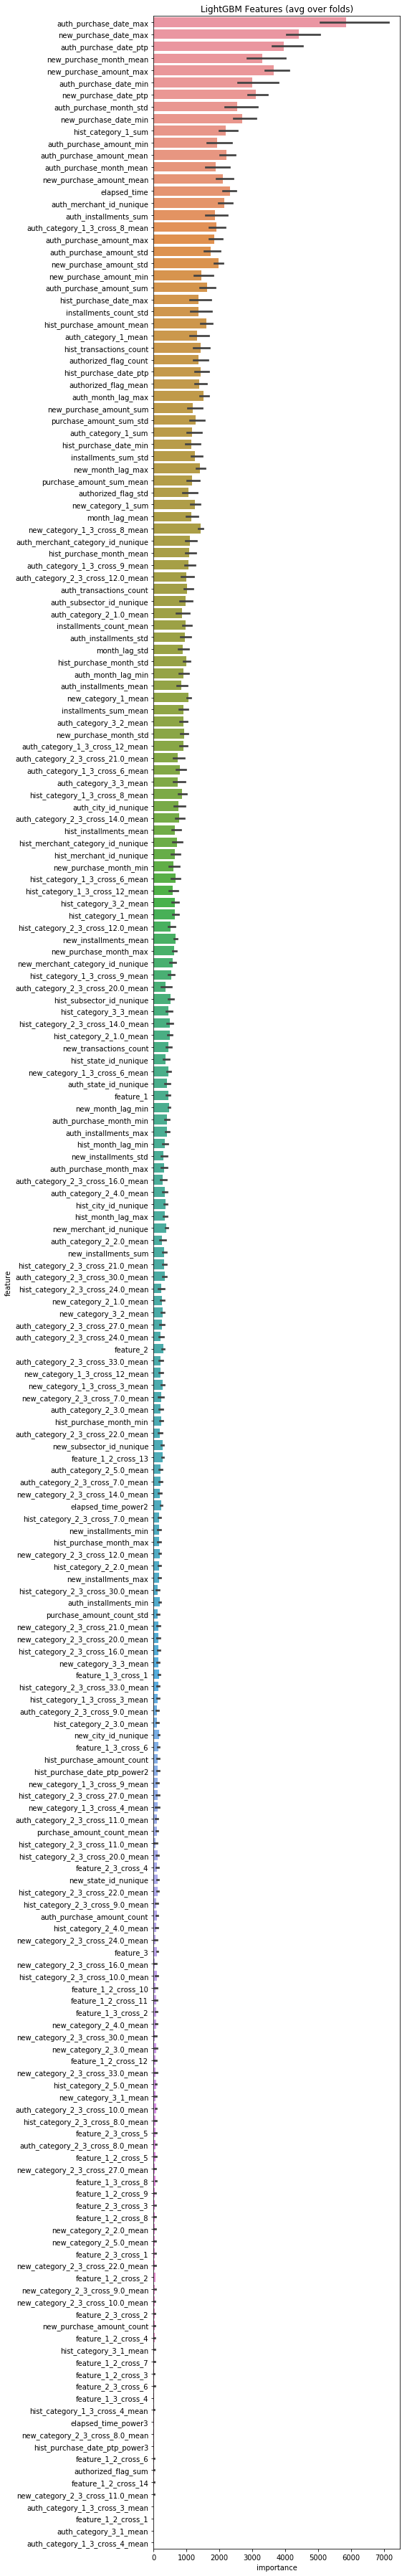

In [63]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(8,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

## LightGBM-1 with Repeated kfold approach

#### RepeatedKFold repeats K-Fold n times. It can be used when one requires to run KFold n times, producing different splits in each repetition.

In [53]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.005,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [54]:
from sklearn.model_selection import RepeatedKFold
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))

fold n°0


/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:1158: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/frank/miniconda2/envs/python35/lib/python3.5/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.73674	valid_1's rmse: 3.77861
[200]	training's rmse: 3.67239	valid_1's rmse: 3.74259
[300]	training's rmse: 3.62691	valid_1's rmse: 3.72449
[400]	training's rmse: 3.59365	valid_1's rmse: 3.71387
[500]	training's rmse: 3.56612	valid_1's rmse: 3.70808
[600]	training's rmse: 3.54243	valid_1's rmse: 3.7037
[700]	training's rmse: 3.52277	valid_1's rmse: 3.69977
[800]	training's rmse: 3.50533	valid_1's rmse: 3.69684
[900]	training's rmse: 3.48965	valid_1's rmse: 3.69397
[1000]	training's rmse: 3.47495	valid_1's rmse: 3.69191
[1100]	training's rmse: 3.46171	valid_1's rmse: 3.69032
[1200]	training's rmse: 3.44904	valid_1's rmse: 3.68919
[1300]	training's rmse: 3.43741	valid_1's rmse: 3.68855
[1400]	training's rmse: 3.42607	valid_1's rmse: 3.68792
[1500]	training's rmse: 3.41518	valid_1's rmse: 3.68742
[1600]	training's rmse: 3.40505	valid_1's rmse: 3.68712
[1700]	training's rmse: 3.39468	valid_1's rmse: 3.6

[2000]	training's rmse: 3.35588	valid_1's rmse: 3.72439
[2100]	training's rmse: 3.34693	valid_1's rmse: 3.72432
[2200]	training's rmse: 3.33844	valid_1's rmse: 3.7241
[2300]	training's rmse: 3.32945	valid_1's rmse: 3.72407
[2400]	training's rmse: 3.3209	valid_1's rmse: 3.72373
Early stopping, best iteration is:
[2394]	training's rmse: 3.32136	valid_1's rmse: 3.7237
fold n°6
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.74138	valid_1's rmse: 3.75741
[200]	training's rmse: 3.67777	valid_1's rmse: 3.72486
[300]	training's rmse: 3.63352	valid_1's rmse: 3.70672
[400]	training's rmse: 3.60067	valid_1's rmse: 3.69596
[500]	training's rmse: 3.5739	valid_1's rmse: 3.68958
[600]	training's rmse: 3.55022	valid_1's rmse: 3.68493
[700]	training's rmse: 3.52984	valid_1's rmse: 3.6806
[800]	training's rmse: 3.51251	valid_1's rmse: 3.67683
[900]	training's rmse: 3.49691	valid_1's rmse: 3.67375
[1000]	training's rmse: 3.48241	valid_1's rmse: 3.67105
[1100]	trai

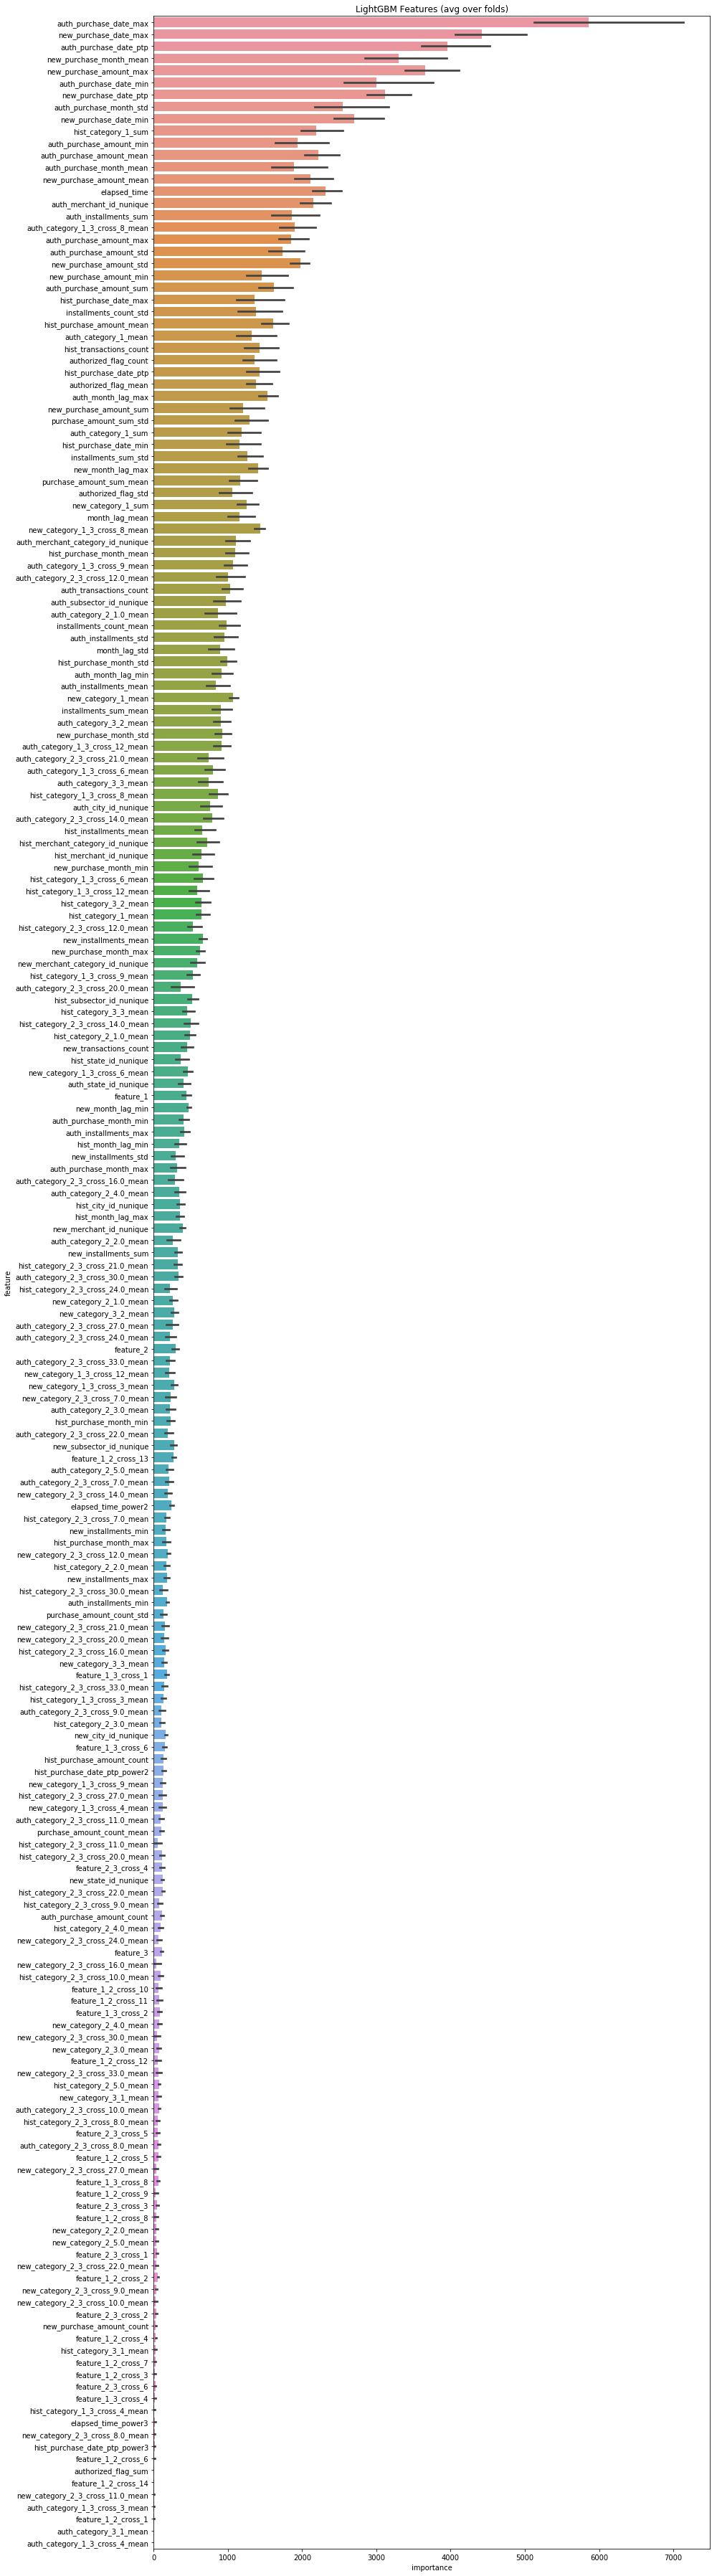

In [70]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('../img/lgbm_importances.png')

In [58]:
best_features.sort_values(by="importance", ascending=False)
feat_list = best_features["feature"].loc[best_features["importance"] > 0]

with open('../input/feat_list.pkl', 'wb') as f:
    pickle.dump([feat_list], f)

In [64]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("../result/submit_lgb.csv", index=False)

sub_df1 = pd.DataFrame({"card_id":test["card_id"].values})
sub_df1["target"] = predictions_lgb
sub_df1.to_csv("../result/submit_lgb1.csv", index=False)

## Stacking

In [69]:
train_stack = np.vstack([oof,oof_lgb]).transpose()
test_stack = np.vstack([predictions,predictions_lgb]).transpose()

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof_stack))

fold n°0
----------Stacking 0----------
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------


3.66482407568106

In [66]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = predictions_stack
sample_submission.to_csv('../result/Bayesian_Ridge_Stacking.csv', index=False)

In [67]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample1 = pd.read_csv("../result/3.695.csv")
sample2 = pd.read_csv("../result/combining_submission (1).csv")
sample_submission['target'] = predictions * 0.5 + predictions_lgb * 0.5
sample_submission.to_csv("../result/Blend1.csv", index = False)
sample_submission['target'] = sample_submission['target'] * 0.2 + sample1['target'] * 0.2 + sample2['target'] * 0.6
sample_submission.to_csv('../result/Blend2.csv', index=False)